<a href="https://colab.research.google.com/github/OksanaSitalova/Sales-Analysis-with-SQL-Python-Tableau/blob/main/Sales_Analysis_with_SQL_Python_Tableau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting to bigquery

In [1]:
!pip install --upgrade google-cloud-bigquery


Importing libraries

In [2]:
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [3]:
auth.authenticate_user()


In [4]:
client = bigquery.Client(project="data-analytics-mate")


# Query

In [5]:
query = """
 SELECT
        s.date AS date,
        s.ga_session_id,
        sp.continent,
        sp.country,
        sp.device,
        sp.browser,
        sp.operating_system,
        sp.language,
        sp.name as channel_info,
        sp.channel AS traffic_channel,
        a.is_verified AS email_verified,
        a.is_unsubscribed AS unsubscribed,
        a.id as account_id,
        p.category AS product_category,
        p.name as product_name,
        p.price as product_price,
        p.short_description
        FROM DA.session s
        LEFT JOIN DA.order o USING(ga_session_id)
        LEFT JOIN DA.product p USING(item_id)
        LEFT JOIN DA.session_params sp USING (ga_session_id)
        LEFT JOIN DA.account_session acs USING (ga_session_id)
        LEFT JOIN DA.account a ON acs.account_id = a.id
"""

query_job = client.query(query)  # Execute the SQL query
results = query_job.result()     # Wait for the query to complete


# Brief description of the dataset

In [6]:
df = results.to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   operating_system   349545 non-null  object 
 7   language           235279 non-null  object 
 8   channel_info       349545 non-null  object 
 9   traffic_channel    349545 non-null  object 
 10  email_verified     27945 non-null   Int64  
 11  unsubscribed       27945 non-null   Int64  
 12  account_id         27945 non-null   Int64  
 13  product_category   33538 non-null   object 
 14  product_name       33538 non-null   object 
 15  product_price      33538 non-null   float64
 16  sh

Total number of columns: 17

Number of numeric columns: 5
(ga_session_id, email_verified, unsubscribed, account_id, product_price)

Number of categorical columns: 11
(continent, country, device, browser, operating_system, language, channel_info, traffic_channel, product_category, product_name, short_description)

Number of datetime columns: 1
(order_date – currently in dbdate format, needs to be converted to datetime64)

Column descriptions:

| Column             | Description                                           |
|--------------------|-------------------------------------------------------|
| `date`             | Date of the user interaction with the site           |
| `ga_session_id`    | Unique identifier of the user's session              |
| `continent`        | Continent of the user's location                     |
| `country`          | User's country based on IP address                   |
| `device`           | Device type (desktop, mobile, tablet)                |
| `browser`          | Browser name                                          |
| `operating_system` | Device operating system                              |
| `language`         | Browser language                                      |
| `channel_info`     | Additional info about the traffic source             |
| `traffic_channel`  | General traffic channel                              |
| `email_verified`   | Email verification status                            |
| `unsubscribed`     | Whether user unsubscribed from emails                |
| `account_id`       | User account identifier                              |
| `product_category` | Product category                                     |
| `product_name`     | Product name                                          |
| `product_price`    | Product price in local currency                      |
| `short_description`| Short product description (dimensions, features)     |





In [7]:
# Convert the 'date' column to datetime64 format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check the resulting data type
df['date'].dtype

dtype('<M8[ns]')

Identify the number of missing values

In [8]:
# Percentage of missing values
missing_percent = ((df.isnull().sum() / len(df) * 100).sort_values(ascending=False)).round(2)
print(missing_percent)

unsubscribed         92.01
email_verified       92.01
account_id           92.01
product_name         90.41
product_category     90.41
product_price        90.41
short_description    90.41
language             32.69
date                  0.00
channel_info          0.00
operating_system      0.00
browser               0.00
device                0.00
continent             0.00
country               0.00
ga_session_id         0.00
traffic_channel       0.00
dtype: float64


Possible reasons for missing data:

account_id, unsubscribed, email_verified (92.01%)
These fields are likely linked to registered users only. If some events occur anonymously (without an account), the data may be missing.

short_description, product_name, product_category, product_price (90.41%)
These might not represent all product-related records. For example, some sessions or events may not involve product interactions (e.g., general page views without a specific item).

language (32.69%)
 Not all users may have selected or passed a language. It’s also possible that language isn’t detected or collected in some sessions.

Columns with no missing values (0.00%)
ga_session_id, order_date, channel_info, operating_system, device_name, browser, country, device, continent, traffic_channel
— most likely technical metadata that is always captured during each session.

Check for duplicates

In [9]:
# Check for fully duplicated rows
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()

num_duplicates

np.int64(0)

There are no fully duplicated rows in the dataset — all rows are unique.

Descriptive statistics for numeric columns

In [10]:
df.describe()

,date,ga_session_id,email_verified,unsubscribed,account_id,product_price
count,349545,349545.0,27945.0,27945.0,27945.0,33538.000000
mean,2020-12-16 12:42:00.602497536,4992250296.631739,0.71698,0.16944,659005.065557,953.298679
min,2020-11-01 00:00:00,1205.0,0.0,0.0,636133.0,3.000000
25%,2020-11-26 00:00:00,2493646855.0,0.0,0.0,647576.0,170.000000
50%,2020-12-15 00:00:00,4988476074.0,1.0,0.0,658952.0,445.000000
75%,2021-01-08 00:00:00,7491286508.0,1.0,0.0,670414.0,1195.000000
max,2021-01-31 00:00:00,9999997129.0,1.0,1.0,681962.0,9585.000000
std,NaN,2887450949.537772,0.450474,0.375147,13216.529465,1317.001775


The product_price column stands out as particularly interesting for analysis. The descriptive statistics show that all values are greater than 0 — there are no zero or negative prices.

It's also important to check for missing values in both the product_price and product_category columns when a purchase has been made.

In [11]:
# Filter rows where product name is present (i.e., a purchase likely occurred)
df_with_product = df[df['product_name'].notna()]

# Check for missing values in product_category and product_price when product_name is available
missing_category = df_with_product['product_category'].isna().sum()
missing_price = df_with_product['product_price'].isna().sum()

missing_category, missing_price

(np.int64(0), np.int64(0))

All rows with a non-null product_name also have:

product_category — not missing

product_price — not missing

This indicates that purchase-related data is complete and consistent.

Check unique values in categorical columns

In [12]:
# Unique values in selected categorical columns
unique_values = {
    'continent': df['continent'].unique(),
    'country': df['country'].unique(),
    'device': df['device'].unique(),
    'browser': df['browser'].unique(),
    'operating_system': df['operating_system'].unique(),
    'language': df['language'].unique(),
    'channel_info': df['channel_info'].unique(),
    'traffic_channel': df['traffic_channel'].unique(),
    'product_category': df['product_category'].unique()
}

unique_values


{'continent': array(['Americas', 'Europe', 'Africa', 'Asia', 'Oceania', '(not set)'],
       dtype=object),
 'country': array(['United States', 'United Kingdom', 'Norway', 'Nigeria', 'China',
        'Germany', '(not set)', 'Ecuador', 'Japan', 'Canada', 'Italy',
        'Indonesia', 'South Korea', 'Belgium', 'Pakistan',
        'United Arab Emirates', 'Uruguay', 'Israel', 'Czechia', 'India',
        'Taiwan', 'Georgia', 'Portugal', 'Thailand', 'Bangladesh',
        'Turkey', 'Vietnam', 'Philippines', 'France', 'Switzerland',
        'Greece', 'Sweden', 'Malaysia', 'Slovenia', 'Argentina',
        'Singapore', 'Spain', 'Brazil', 'Denmark', 'Dominican Republic',
        'Australia', 'Mexico', 'Colombia', 'Netherlands', 'Poland',
        'Lithuania', 'Ukraine', 'Chile', 'Oman', 'Ireland', 'Kuwait',
        'New Zealand', 'Peru', 'Sri Lanka', 'Tunisia', 'Lebanon',
        'Puerto Rico', 'Saudi Arabia', 'Egypt', 'Slovakia',
        'Bosnia & Herzegovina', 'El Salvador', 'Bahrain', 'Jordan',

There are a few suspicious values:

(not set) in continent and country

<Other> or (data deleted) in traffic source fields

NaN in the language column

# General statistics for the dataset

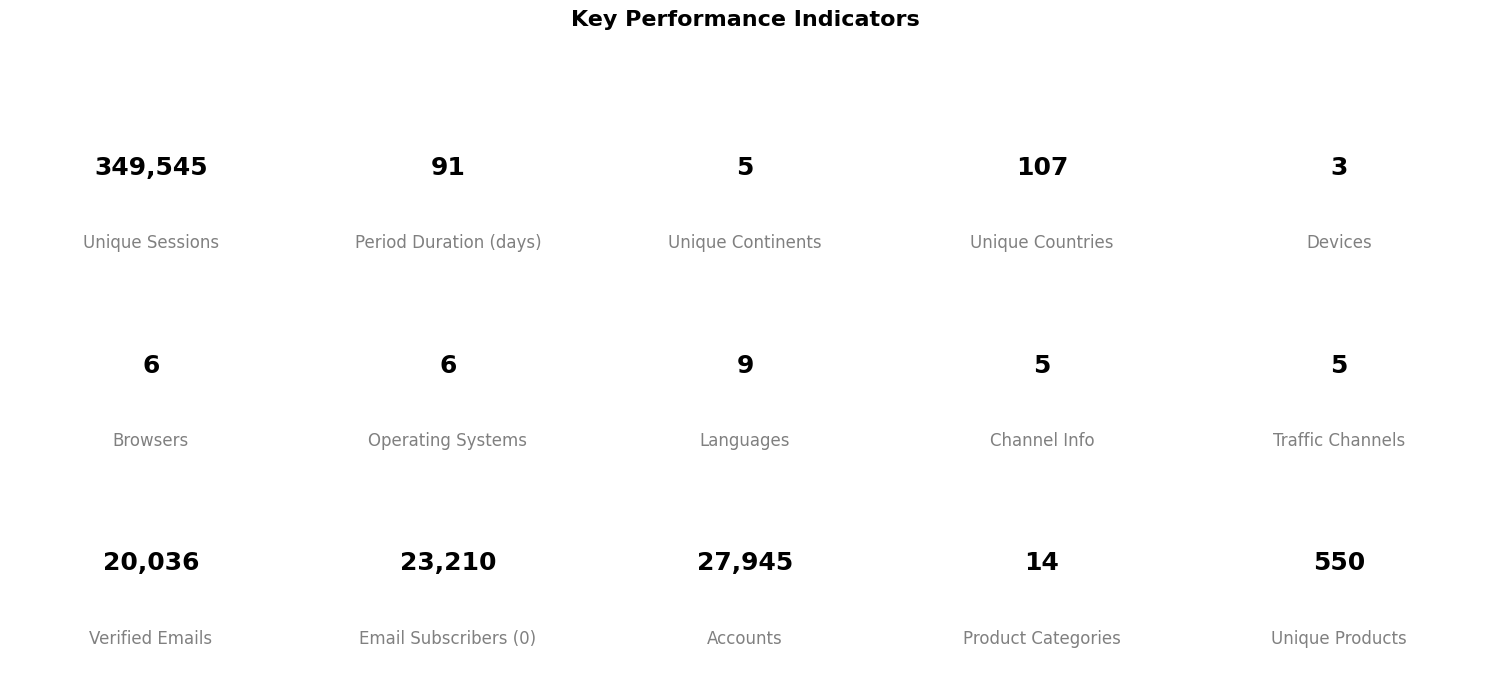

In [13]:
# KPI generation
kpi_values = {
    "KPI": [
        "Unique Sessions", "Period Duration (days)", "Unique Continents", "Unique Countries",
        "Devices", "Browsers", "Operating Systems", "Languages",
        "Channel Info", "Traffic Channels", "Verified Emails", "Email Subscribers (0)",
        "Accounts", "Product Categories", "Unique Products"
    ],
    "Value": [
        df['ga_session_id'].nunique(),
        (df['date'].max() - df['date'].min()).days,
        df[df['continent'] != '(not set)']['continent'].nunique(),
        df[df['country'] != '(not set)']['country'].nunique(),
        df['device'].nunique(),
        df['browser'].nunique(),
        df['operating_system'].nunique(),
        df['language'].nunique(),
        df['channel_info'].nunique(),
        df['traffic_channel'].nunique(),
        df[df['email_verified'] == True]['account_id'].nunique(),
        (df['unsubscribed'] == 0).sum(),
        df['account_id'].count(),
        df['product_category'].nunique(),
        df['product_name'].nunique()
    ]
}

# Building KPI tiles
fig, ax = plt.subplots(3, 5, figsize=(15, 7))
fig.suptitle('Key Performance Indicators', fontsize=16, fontweight='bold')

# Loop through and render each metric
kpi_items = list(zip(kpi_values["KPI"], kpi_values["Value"]))

for i, axis in enumerate(ax.flat):
    if i < len(kpi_items):
        kpi, value = kpi_items[i]
        axis.text(0.5, 0.6, f"{value:,}", fontsize=18, fontweight='bold', ha='center')
        axis.text(0.5, 0.2, kpi, fontsize=12, color='gray', ha='center')
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_frame_on(False)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


 Calculate conversion rate, total revenue, average check, and total number of purchases

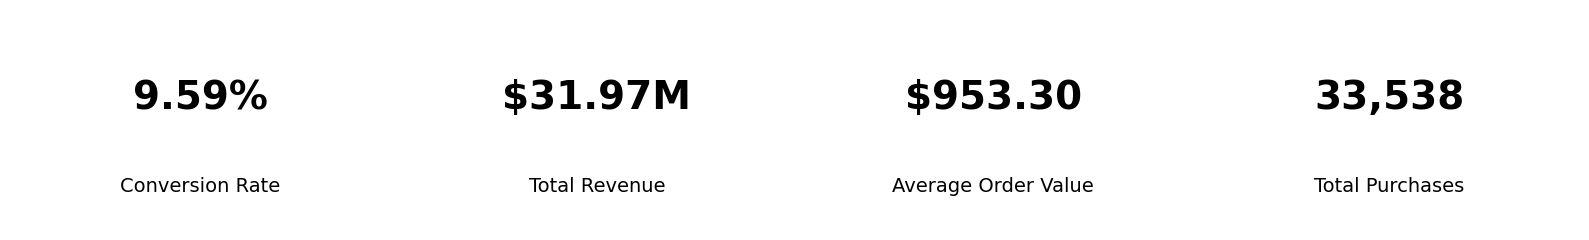

In [14]:
# Unique sessions
total_sessions = df['ga_session_id'].nunique()

# Sessions with purchases
purchase_sessions = df[df['product_price'] > 0]['ga_session_id'].nunique()

# Conversion Rate (%)
conversion_value = round((purchase_sessions / total_sessions) * 100, 2)

# Total Revenue (in millions)
total_revenue = df['product_price'].sum()
total_revenue_fmt = f"${total_revenue / 1_000_000:.2f}M"

# Average Order Value
valid_sales = df[df['product_price'].notna() & df['ga_session_id'].notna()]
aov = valid_sales['product_price'].sum() / valid_sales['ga_session_id'].nunique()
aov_fmt = f"${aov:.2f}"

# Purchase Count
purchase_count = df[df['product_price'].notna()].shape[0]
purchase_count_fmt = f"{purchase_count:,}"

# Build 4 KPI tiles
fig, axs = plt.subplots(1, 4, figsize=(16, 2.5))

# KPI: Conversion Rate
axs[0].text(0.5, 0.6, f'{conversion_value}%', fontsize=28, ha='center', va='center', fontweight='bold')
axs[0].text(0.5, 0.2, 'Conversion Rate', fontsize=14, ha='center', va='center')
axs[0].axis('off')

# KPI: Total Revenue
axs[1].text(0.5, 0.6, total_revenue_fmt, fontsize=28, ha='center', va='center', fontweight='bold')
axs[1].text(0.5, 0.2, 'Total Revenue', fontsize=14, ha='center', va='center')
axs[1].axis('off')

# KPI: Average Order Value
axs[2].text(0.5, 0.6, aov_fmt, fontsize=28, ha='center', va='center', fontweight='bold')
axs[2].text(0.5, 0.2, 'Average Order Value', fontsize=14, ha='center', va='center')
axs[2].axis('off')

# KPI: Purchase Count
axs[3].text(0.5, 0.6, purchase_count_fmt, fontsize=28, ha='center', va='center', fontweight='bold')
axs[3].text(0.5, 0.2, 'Total Purchases', fontsize=14, ha='center', va='center')
axs[3].axis('off')

plt.tight_layout()
plt.show()

# Analysis of sales geography
Identify Top 3 continents by revenue and number of sales

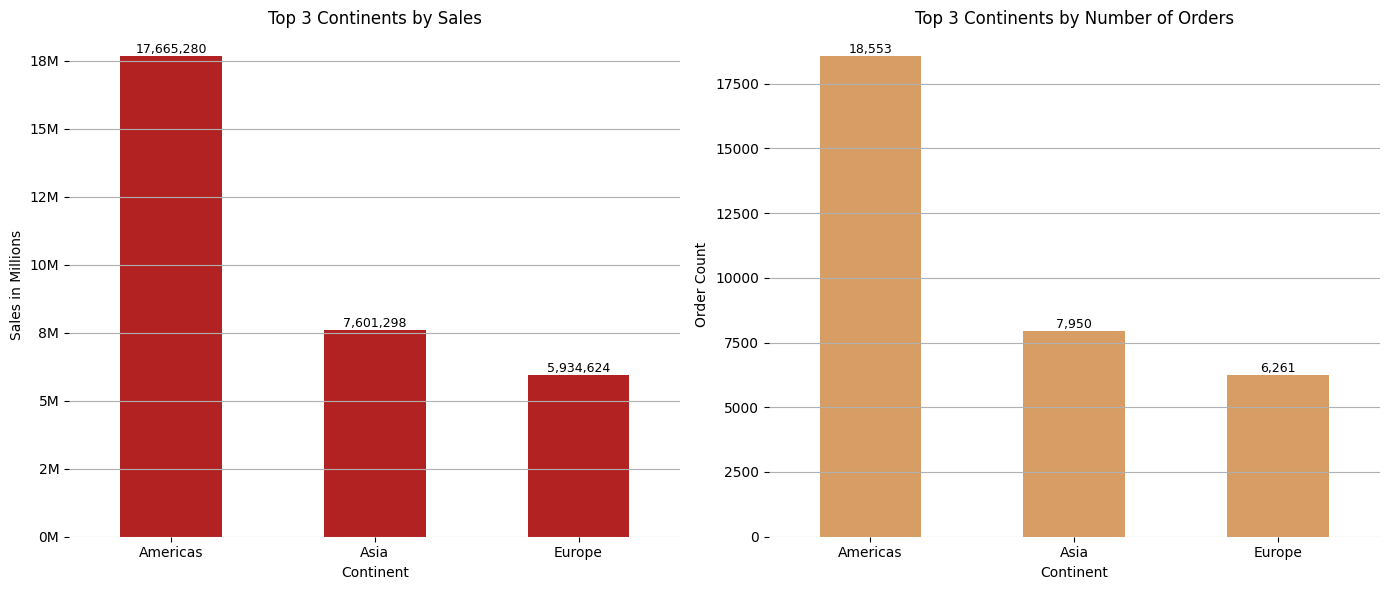

In [15]:
# Create a DataFrame with purchases
sales_df = df[df['product_price'].notnull()]

# Top 3 continents by total sales
top_continents_by_sales = (sales_df.groupby('continent')['product_price'].sum().sort_values(ascending=False).head(3))

# Top 3 continents by number of orders
top_continents_by_orders = (sales_df['continent'].value_counts().head(3))

# Format Y-axis in millions
from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    return f'{x * 1e-6:.0f}M'

# Create vertical bar charts with horizontal category labels (Continent)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1 — Total sales by continent
ax1 = top_continents_by_sales.plot(kind='bar', color='firebrick', ax=axs[0])
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
axs[0].set_title('Top 3 Continents by Sales')
axs[0].set_ylabel('Sales in Millions')
axs[0].set_xlabel('Continent')
axs[0].tick_params(axis='x', rotation=0)  # Keep labels horizontal
axs[0].grid(axis='y')
for spine in ax1.spines.values():
    spine.set_visible(False)
for i, v in enumerate(top_continents_by_sales):
    axs[0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

# Chart 2 — Number of orders by continent
ax2 = top_continents_by_orders.plot(kind='bar', color='peru', ax=axs[1], alpha=0.8)
axs[1].set_title('Top 3 Continents by Number of Orders')
axs[1].set_ylabel('Order Count')
axs[1].set_xlabel('Continent')
axs[1].tick_params(axis='x', rotation=0)  # Keep labels horizontal
axs[1].grid(axis='y')
for spine in ax2.spines.values():
    spine.set_visible(False)
for i, v in enumerate(top_continents_by_orders):
    axs[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



Identify Top 10 countries by revenue and number of sales

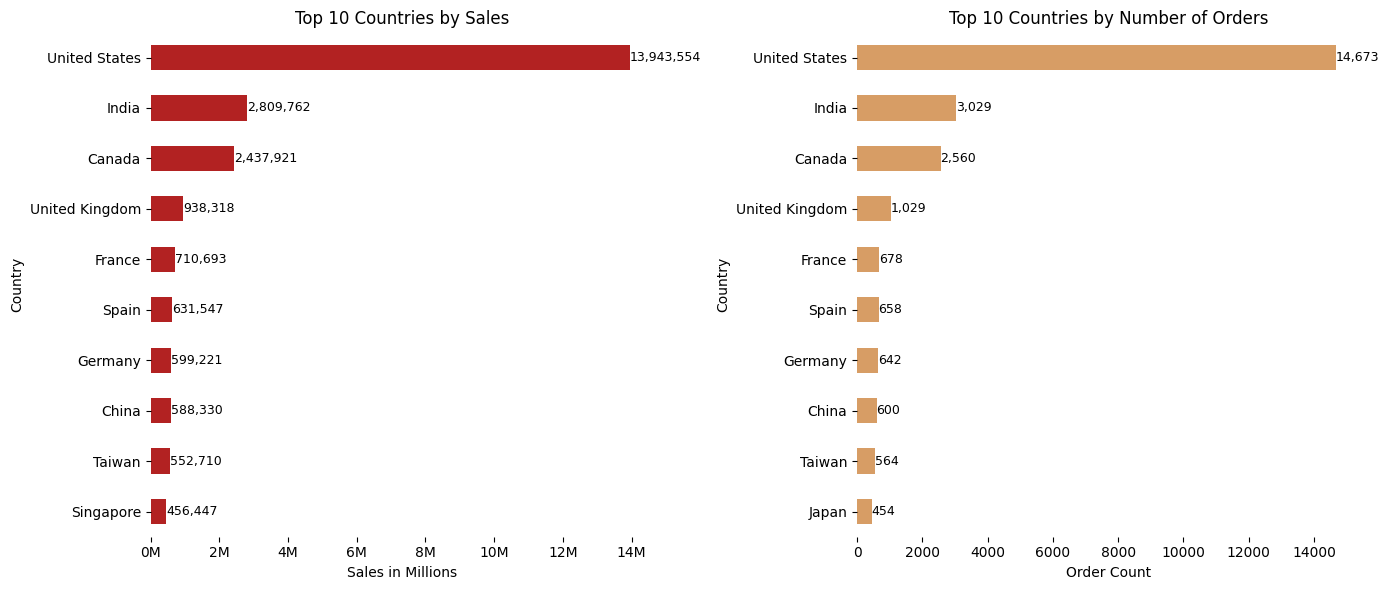

In [16]:
# Top 10 countries by total sales
top_countries_by_sales = (sales_df.groupby('country')['product_price'].sum().sort_values(ascending=False).head(10))

# Top 10 countries by number of orders
top_countries_by_orders = (sales_df['country'].value_counts().head(10))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1 — Total sales by country (horizontal)
ax1 = top_countries_by_sales.plot(kind='barh', color='firebrick', ax=axs[0])
ax1.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
axs[0].set_title('Top 10 Countries by Sales')
axs[0].set_xlabel('Sales in Millions')
axs[0].set_ylabel('Country')
axs[0].invert_yaxis()
# Remove borders
for spine in ax1.spines.values():
    spine.set_visible(False)
# Add value labels
for i, v in enumerate(top_countries_by_sales):
    axs[0].text(v, i, f'{v:,.0f}', va='center', ha='left', fontsize=9)

# Chart 2 — Number of orders by country (horizontal)
ax2 = top_countries_by_orders.plot(kind='barh', color='peru', ax=axs[1], alpha=0.8)
axs[1].set_title('Top 10 Countries by Number of Orders')
axs[1].set_xlabel('Order Count')
axs[1].set_ylabel('Country')
axs[1].invert_yaxis()
# Remove borders
for spine in ax2.spines.values():
    spine.set_visible(False)
# Add value labels
for i, v in enumerate(top_countries_by_orders):
    axs[1].text(v, i, f'{v:,}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()



Total sales by country (overall map)

In [17]:
# Filter purchase records
sales_df = df[df['product_price'].notnull() & (df['country'] != '(not set)')]

# Group by country and calculate total sales
country_sales = (sales_df.groupby('country')['product_price'].sum().reset_index()
    .rename(columns={'product_price': 'total_sales'}))

# Plot the map
fig = px.choropleth(
    country_sales,
    locations='country',
    locationmode='country names',
    color='total_sales',
    color_continuous_scale='OrRd',
    title='Total Sales by Country',
    labels={'total_sales': 'Sales (USD)'},
    width=1000,        # width in pixels
    height=600         # height in pixels
)

fig.update_geos(showcountries=True, showframe=False, showcoastlines=True)
fig.show()


Total sales by country (Europe only)

In [18]:
# Filter data for Europe only
europe_sales = (sales_df[sales_df['continent'] == 'Europe'].query("country != '(not set)'").groupby('country')['product_price'].sum().reset_index().rename(columns={'product_price': 'total_sales'}))

# Plot sales map for Europe
fig = px.choropleth(
    europe_sales,
    locations='country',
    locationmode='country names',
    color='total_sales',
    color_continuous_scale='OrRd',
    title='Total Sales by Country in Europe',
    labels={'total_sales': 'Sales (UAH)'},
    scope='europe',        # limit view to Europe
    width=900,
    height=600
)

fig.update_geos(showcountries=True, showframe=False, showcoastlines=True)
fig.show()



Total sales by country (North America)

In [19]:
# Filter data for the "Americas" continent
americas_sales = (
    sales_df[sales_df['continent'] == 'Americas']
    .query("country != '(not set)'")
    .groupby('country')['product_price']
    .sum()
    .reset_index()
    .rename(columns={'product_price': 'total_sales'})
)

# Plot sales map for the Americas
fig = px.choropleth(
    americas_sales,
    locations='country',
    locationmode='country names',
    color='total_sales',
    color_continuous_scale='OrRd',
    title='Total Sales by Country in North America',
    labels={'total_sales': 'Sales (UAH)'},
    scope='north america',   # covers North, Central, and parts of South America
    width=900,
    height=600
)

fig.update_geos(showcountries=True, showframe=False, showcoastlines=True)
fig.show()


Total sales by country (Asia)

In [20]:
# Filter data for the "Asia" continent
asia_sales = (
    sales_df[sales_df['continent'] == 'Asia']
    .query("country != '(not set)'")
    .groupby('country')['product_price']
    .sum()
    .reset_index()
    .rename(columns={'product_price': 'total_sales'})
)

# Plot sales map for Asia
fig = px.choropleth(
    asia_sales,
    locations='country',
    locationmode='country names',
    color='total_sales',
    color_continuous_scale='OrRd',
    title='Total Sales by Country in Asia',
    labels={'total_sales': 'Sales (UAH)'},
    scope='asia',   # Correct scope value
    width=900,
    height=600
)

fig.update_geos(showcountries=True, showframe=False, showcoastlines=True)
fig.show()



Identify countries with the highest conversion rates








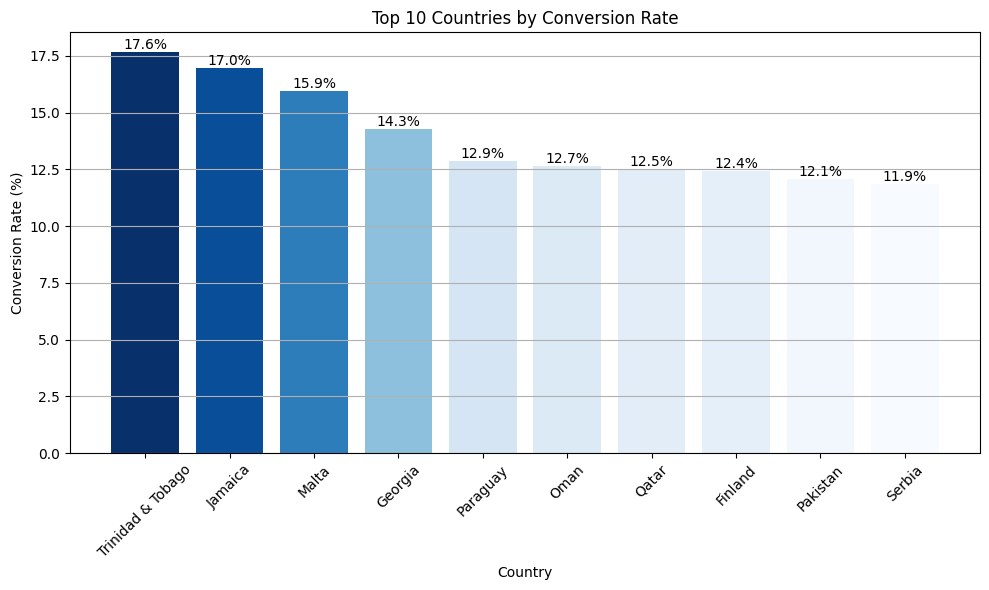

In [21]:
# Unique sessions by country (only where country is specified)
total_sessions_by_country = (
    df[df['country'] != '(not set)']
    .groupby('country')['ga_session_id']
    .nunique()
    .rename('total_sessions')
)

# Purchase sessions by country
purchase_sessions_by_country = (
    df[(df['product_price'] > 0) & (df['country'] != '(not set)')]
    .groupby('country')['ga_session_id']
    .nunique()
    .rename('purchase_sessions')
)

# Merge tables and calculate conversion rate
conversion_by_country = pd.concat(
    [total_sessions_by_country, purchase_sessions_by_country], axis=1
)
conversion_by_country['conversion_rate_%'] = (
    conversion_by_country['purchase_sessions'] / conversion_by_country['total_sessions']
) * 100

# Round results
conversion_by_country = conversion_by_country.round(2)

# Sort by conversion rate
conversion_by_country_sorted = conversion_by_country.sort_values(by='conversion_rate_%', ascending=False)

# Take top 10 countries by conversion rate
top10_conversion = conversion_by_country_sorted.head(10)

# Normalize values for color map (0–1)
norm = plt.Normalize(top10_conversion['conversion_rate_%'].min(),
                     top10_conversion['conversion_rate_%'].max())

# Select color map
colors = cm.Blues(norm(top10_conversion['conversion_rate_%']))

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(top10_conversion.index, top10_conversion['conversion_rate_%'], color=colors)
plt.title('Top 10 Countries by Conversion Rate')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Analysis by categories

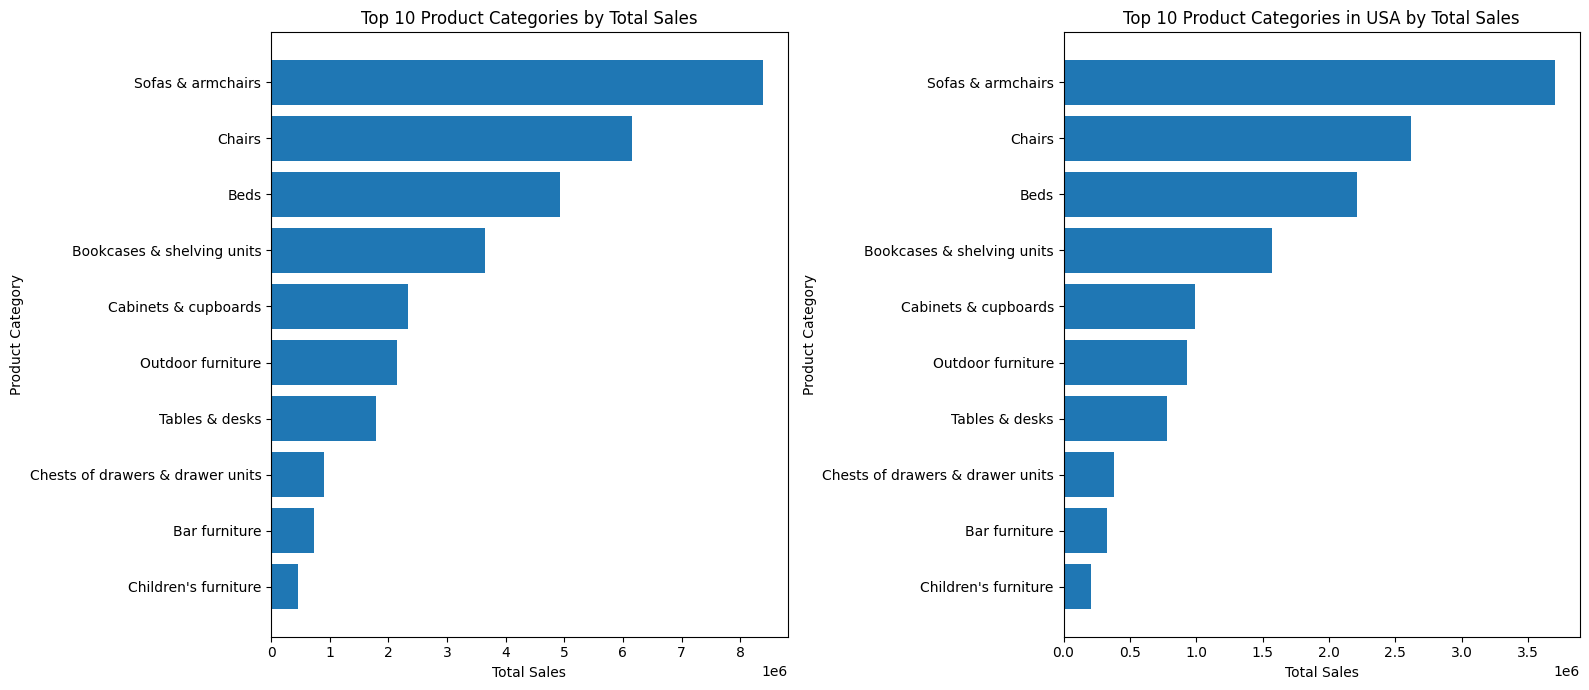

In [22]:
# Filter valid product categories
df_valid = df[df['product_category'].notna()]

# Top 10 categories by total sales (overall)
top10_categories = (
    df_valid.groupby('product_category')['product_price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Top 10 categories by total sales in the USA
usa_df = df_valid[df_valid['country'] == 'United States']
top10_usa_categories = (
    usa_df.groupby('product_category')['product_price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Plot charts
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Chart 1: Overall sales
axes[0].barh(top10_categories['product_category'], top10_categories['product_price'])
axes[0].invert_yaxis()
axes[0].set_title('Top 10 Product Categories by Total Sales')
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Product Category')

# Chart 2: Sales in the USA
axes[1].barh(top10_usa_categories['product_category'], top10_usa_categories['product_price'])
axes[1].invert_yaxis()
axes[1].set_title('Top 10 Product Categories in USA by Total Sales')
axes[1].set_xlabel('Total Sales')
axes[1].set_ylabel('Product Category')

plt.tight_layout()
plt.show()


Demand is consistent across categories both globally and in the USA — the same furniture types lead in sales.

The US market generates approximately 40–45% of the global sales volume in the top categories.

Niche categories like Children's furniture and Bar furniture remain small in terms of sales volume.

Identify the most profitable products

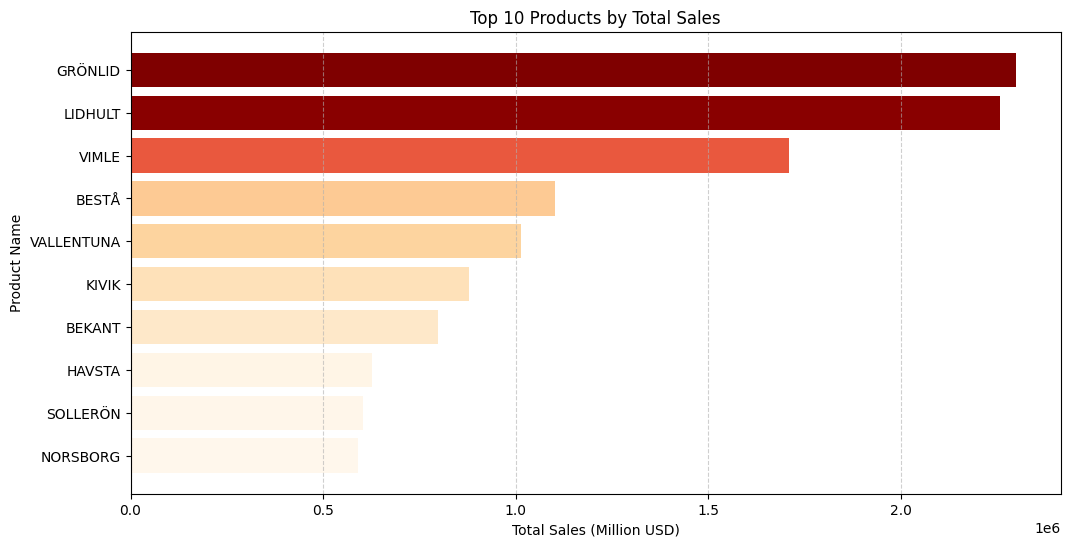

In [23]:
# Group by product_name and calculate total sales
top10_products = (
    df[df['product_name'].notna()]
    .groupby('product_name')['product_price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'product_price': 'total_sales'})
)

# Normalize values (for gradient coloring)
norm = mcolors.Normalize(vmin=top10_products['total_sales'].min(),
                         vmax=top10_products['total_sales'].max())

# Choose a color map (e.g., 'OrRd' or 'Blues')
cmap = plt.colormaps['OrRd']

# Generate colors with descending saturation
colors = [cmap(norm(value)) for value in top10_products['total_sales']]

# Plot horizontal bar chart with X-axis formatted in millions
plt.figure(figsize=(12, 6))
bars = plt.barh(top10_products['product_name'], top10_products['total_sales'], color=colors)
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales (Million USD)')
plt.ylabel('Product Name')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

ount product assortment within each category

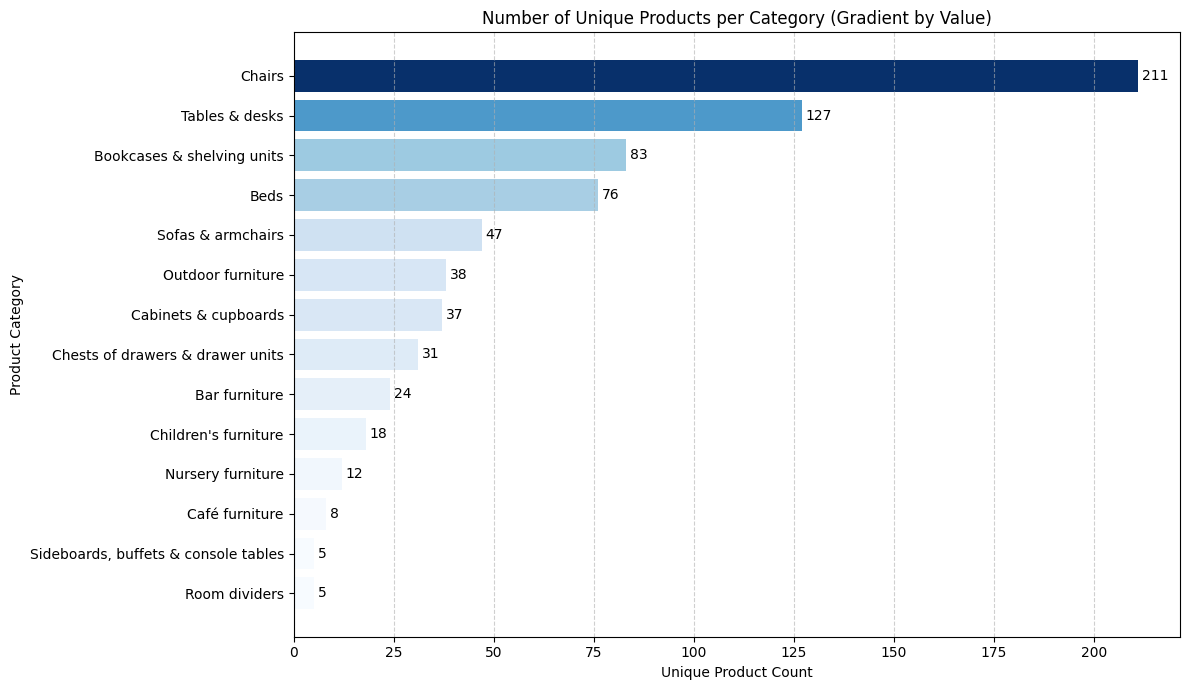

In [46]:
# Sort in ascending order
unique_products_per_category = (
    df.groupby("product_category")["product_name"]
    .nunique()
    .sort_values()
)

# Create normalization and color map
norm = mcolors.Normalize(vmin=unique_products_per_category.min(),
                         vmax=unique_products_per_category.max())
cmap = plt.colormaps['Blues']

# Generate colors
colors = [cmap(norm(value)) for value in unique_products_per_category.values]

# Plot the chart
plt.figure(figsize=(12, 7))
bars = plt.barh(
    unique_products_per_category.index,
    unique_products_per_category.values,
    color=colors
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{int(width)}", va='center', ha='left')

plt.title("Number of Unique Products per Category (Gradient by Value)")
plt.xlabel("Unique Product Count")
plt.ylabel("Product Category")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The Chairs category dominates in product variety, which may be due to high demand or broad manufacturer specialization.

Main furniture categories (tables, bookcases, beds) also have a large assortment, reflecting their popularity.

Niche categories have growth potential or require a dedicated marketing strategy.

# Sales distribution by device types and analysis including calculations of various metrics across different user groups.

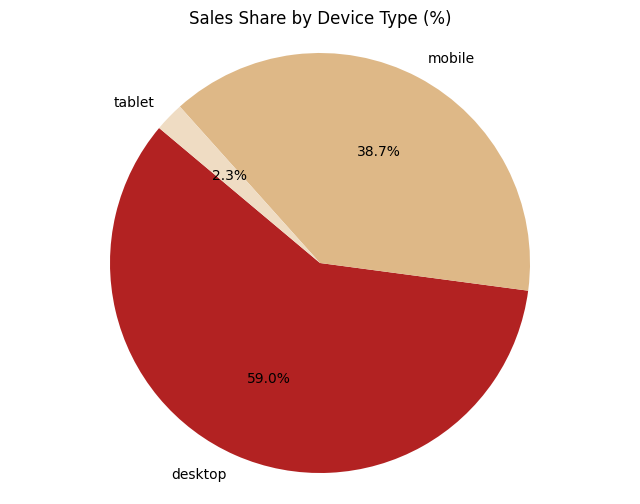

In [25]:
# Total sales amount
total_sales = df['product_price'].sum()

# Sales breakdown by device types
device_sales = (
    df[df['device'].notna()]
    .groupby('device')['product_price']
    .sum()
    .reset_index()
    .rename(columns={'product_price': 'device_sales'})
)

# Calculate percentage share of total sales
device_sales['share_percent'] = (device_sales['device_sales'] / total_sales) * 100

# Sort descending by share
device_sales = device_sales.sort_values(by='share_percent', ascending=False).reset_index(drop=True)

# Round values
device_sales['device_sales'] = device_sales['device_sales'] / 1_000_000  # in millions
device_sales['share_percent'] = device_sales['share_percent'].round(2)

colors = ['firebrick', '#DEB887', '#efdcc3']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    device_sales['share_percent'],
    labels=device_sales['device'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title('Sales Share by Device Type (%)')
plt.axis('equal')
plt.show()


Sales distribution between registered and unregistered users

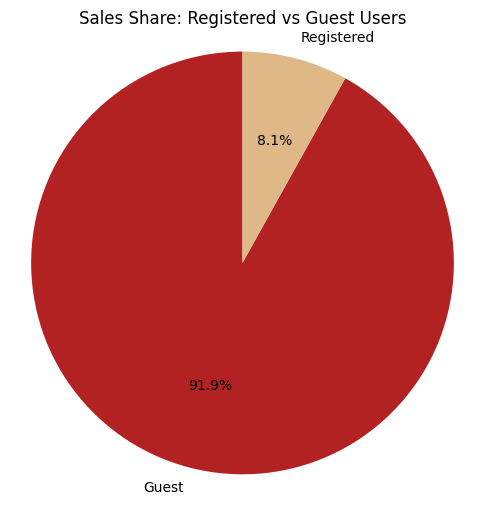

In [26]:
# Add feature: registered user or not
df['is_registered'] = df['account_id'].notna()

# Aggregate sales by groups
sales_by_registration = (
    df[df['product_price'].notna()]
    .groupby('is_registered')['product_price']
    .sum()
    .reset_index()
    .rename(columns={'product_price': 'total_sales'})
)

# Add percentage share
total_sales_all = sales_by_registration['total_sales'].sum()
sales_by_registration['share_percent'] = (sales_by_registration['total_sales'] / total_sales_all * 100).round(2)

# Rename True/False to understandable labels
sales_by_registration['user_type'] = sales_by_registration['is_registered'].map({True: 'Registered', False: 'Guest'})
sales_by_registration = sales_by_registration[['user_type', 'total_sales', 'share_percent']]

# Plot pie chart for shares of registered and guest users
plt.figure(figsize=(6, 6))
plt.pie(
    sales_by_registration['share_percent'],
    labels=sales_by_registration['user_type'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['firebrick', '#DEB887']
)
plt.title('Sales Share: Registered vs Guest Users')
plt.axis('equal')
plt.show()


Відсоток зареєстрованих користувачів які відписались від розсилки

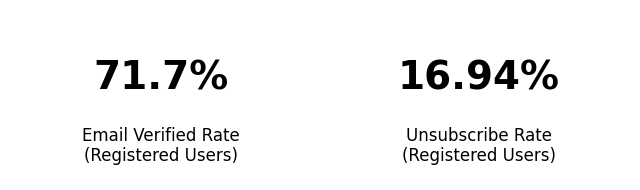

In [27]:
# Select only registered users
registered_users = df[df['account_id'].notna()]

# Total number of unique registered users
total_registered = registered_users['account_id'].nunique()

# Number of registered users who unsubscribed (unsubscribed == True)
unsubscribed_registered = (
    registered_users[registered_users['unsubscribed'] == True]['account_id']
    .nunique()
)

# Calculate unsubscribe rate percentage
unsubscribe_rate = round((unsubscribed_registered / total_registered) * 100, 2)
unsubscribe_rate

# Total number of registered users
total_registered_users = registered_users['account_id'].nunique()

# Number of users who verified their email (email_verified == True)
verified_users = (
    registered_users[registered_users['email_verified'] == True]['account_id']
    .nunique()
)

# Calculate email verified rate percentage
verified_rate = round((verified_users / total_registered_users) * 100, 2)

# Plot 2 KPI tiles: Unsubscribe Rate + Email Verified Rate
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2))

# KPI: Email Verified Rate
axs[0].text(0.5, 0.6, f'{verified_rate}%', fontsize=28, ha='center', va='center', fontweight='bold')
axs[0].text(0.5, 0.2, 'Email Verified Rate\n(Registered Users)', fontsize=12, ha='center', va='center')
axs[0].axis('off')

# KPI: Unsubscribe Rate
axs[1].text(0.5, 0.6, f'{unsubscribe_rate}%', fontsize=28, ha='center', va='center', fontweight='bold')
axs[1].text(0.5, 0.2, 'Unsubscribe Rate\n(Registered Users)', fontsize=12, ha='center', va='center')
axs[1].axis('off')

plt.tight_layout()
plt.show()


Compare average check between subscribed and unsubscribed users

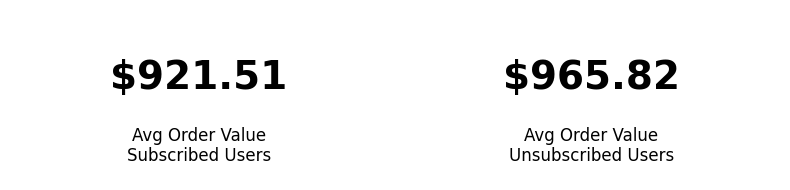

In [28]:
# Filter registered users with valid account_id and product price
registered_sales = df[df['account_id'].notna() & df['product_price'].notna()]

# Group by account_id and unsubscribed status to avoid duplicates
user_sales = (
    registered_sales
    .groupby(['account_id', 'unsubscribed'])['product_price']
    .sum()
    .reset_index()
)

# Create two groups: unsubscribed and subscribed users
unsubscribed_group = user_sales[user_sales['unsubscribed'] == True]['product_price']
subscribed_group = user_sales[user_sales['unsubscribed'] != True]['product_price']  # False or NaN

# Calculate average order value for both groups
avg_subscribed = subscribed_group.mean()
avg_unsubscribed = unsubscribed_group.mean()

# Format values
avg_subscribed_fmt = f"${avg_subscribed:.2f}"
avg_unsubscribed_fmt = f"${avg_unsubscribed:.2f}"

# Plot KPI cards
fig, axs = plt.subplots(1, 2, figsize=(8, 2))

# KPI: Subscribed Users
axs[0].text(0.5, 0.6, avg_subscribed_fmt, fontsize=28, ha='center', va='center', fontweight='bold')
axs[0].text(0.5, 0.2, 'Avg Order Value\nSubscribed Users', fontsize=12, ha='center', va='center')
axs[0].axis('off')

# KPI: Unsubscribed Users
axs[1].text(0.5, 0.6, avg_unsubscribed_fmt, fontsize=28, ha='center', va='center', fontweight='bold')
axs[1].text(0.5, 0.2, 'Avg Order Value\nUnsubscribed Users', fontsize=12, ha='center', va='center')
axs[1].axis('off')

plt.tight_layout()
plt.show()


Users who unsubscribed from the mailing list actually spent slightly more on average.

This may indicate that:

Unsubscribing does not necessarily mean a loss of interest in the product.

Possibly, these users have already made several large purchases and prefer not to receive emails.

# Sales dynamics analysis

Overall sales dynamics

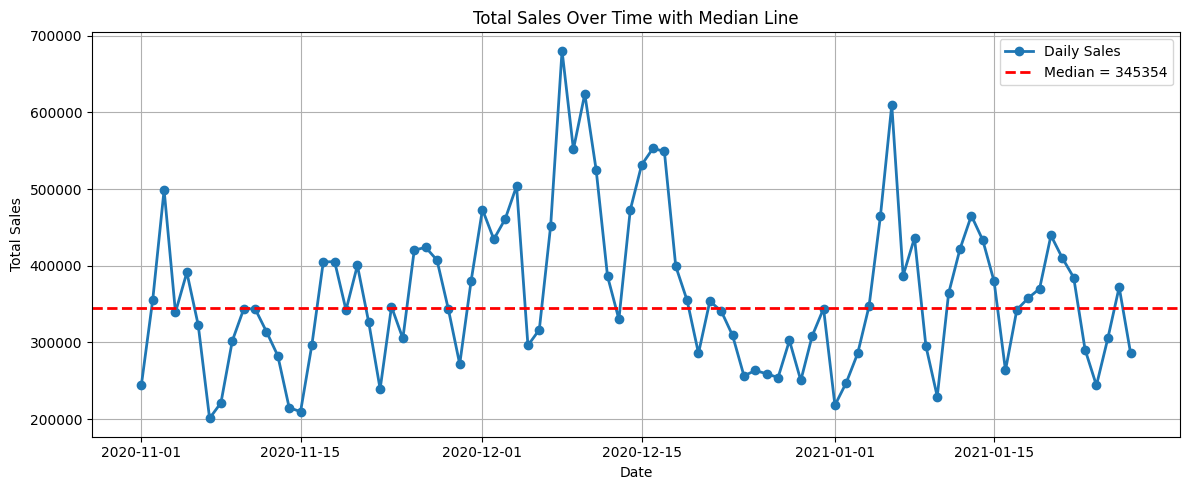

In [29]:
# Group by date and calculate total sales
daily_sales = (
    df[df['product_price'].notna()]
    .groupby('date')['product_price']
    .sum()
    .reset_index()
    .rename(columns={'product_price': 'total_sales'})
)

# Calculate median of total daily sales
median_sales = daily_sales['total_sales'].median()

# Plot the graph with median line
plt.figure(figsize=(12, 5))
plt.plot(daily_sales['date'], daily_sales['total_sales'], marker='o', linewidth=2, label='Daily Sales')
plt.axhline(median_sales, color='red', linestyle='--', linewidth=2, label=f'Median = {median_sales:.0f}')

plt.title('Total Sales Over Time with Median Line')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Sales show an unstable dynamic with pronounced peaks, notably in December 2020, likely due to holiday promotions. Most days fluctuate around the median level of approximately 345K, without sustained growth or decline, indicating no clear trend. This pattern suggests possible seasonality in demand and highlights the need for further analysis by channels, weekdays, or devices.

Sales dynamics broken down by continents

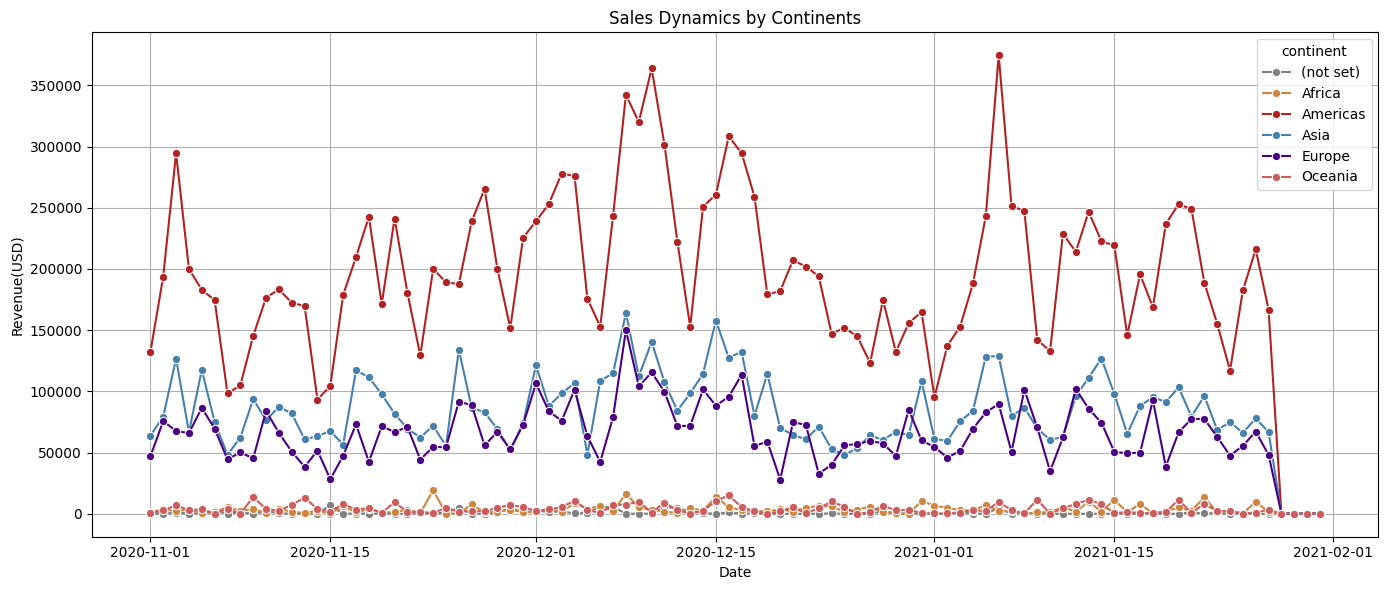

In [30]:
# Group data by date and continent for all continents
sales_all_by_continent = (df.groupby(['date', 'continent'])['product_price'].sum().reset_index(name='total_sales'))

# Plotting the graph
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=sales_all_by_continent,
    x='date',
    y='total_sales',
    hue='continent',
    marker='o', palette=['grey', 'peru', "#b22222", '#4680AD', "#4b0082", '#CD5C5C'])

plt.title('Sales Dynamics by Continents')
plt.ylabel('Revenue(USD)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

The Americas generate the majority of sales, showing both stability and seasonal spikes. Asia and Europe are important secondary markets with moderate activity. Other continents have minimal impact and may represent areas for potential growth or require data collection improvements (e.g., entries labeled as "(not set)").

Sales dynamics broken down by traffic channels

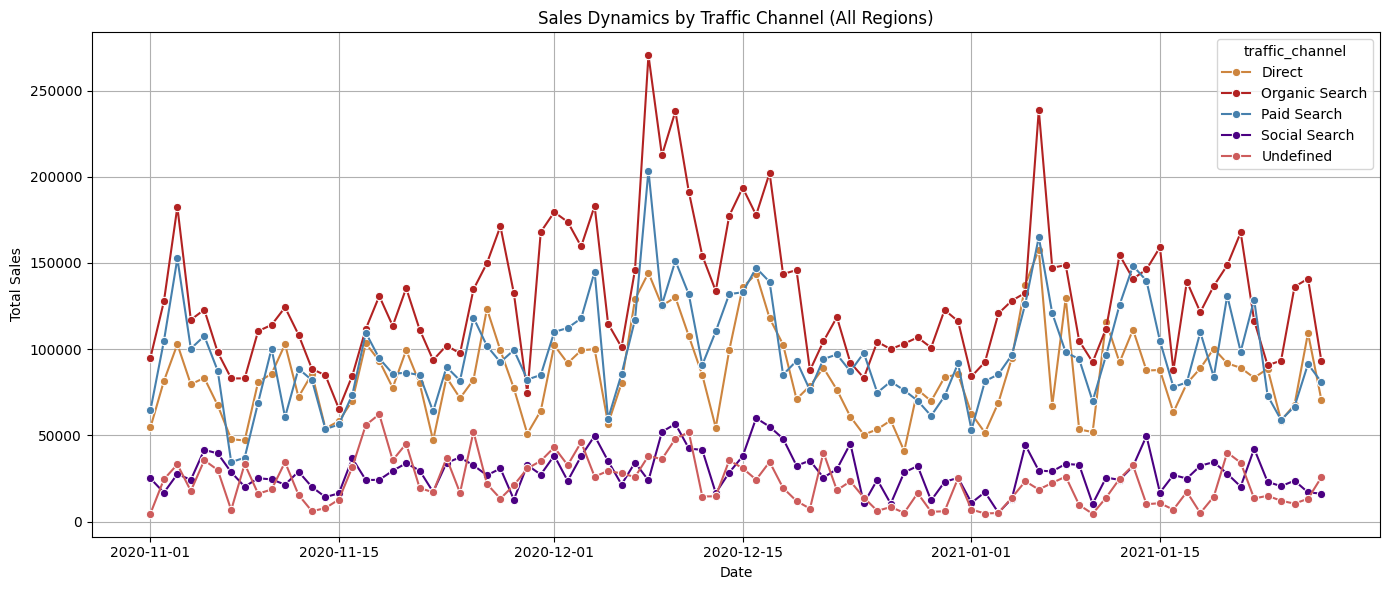

In [31]:
# Group data by date and traffic channel (only valid sales and traffic channel)
sales_all_by_channel = (
    df[df['product_price'].notna() & df['traffic_channel'].notna()]
    .groupby(['date', 'traffic_channel'])['product_price']
    .sum()
    .reset_index(name='total_sales')
)

# Plotting the graph
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=sales_all_by_channel,
    x='date',
    y='total_sales',
    hue='traffic_channel',
    marker='o',
    palette=['peru', "#b22222", '#4680AD', "#4b0082", '#CD5C5C']
)
plt.title('Sales Dynamics by Traffic Channel (All Regions)')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()



Organic Search shows the highest volumes, with significant fluctuations likely related to holidays and seasonality.

Paid Search and Direct channels maintain moderate levels, also exhibiting fluctuations similar to Organic Search.

Social Search is the least variable and consistently low.

It is also important to investigate the causes of the high share of Undefined to avoid loss of analytical accuracy.

Sales dynamics broken down by device types

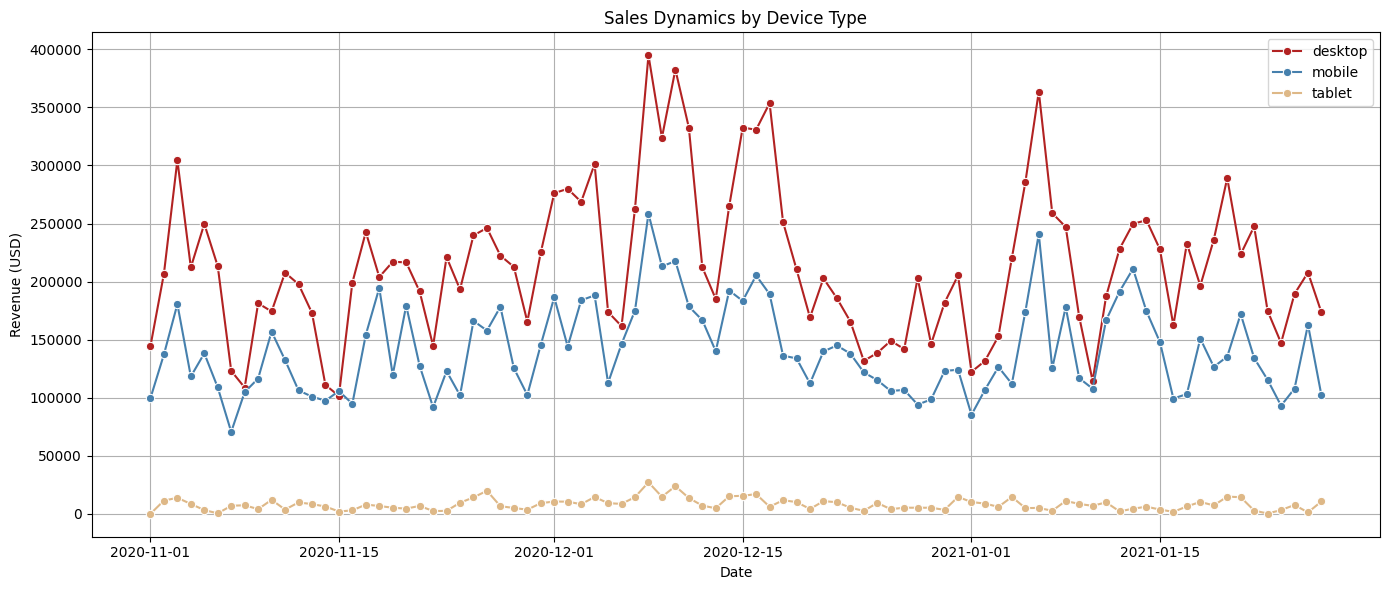

In [32]:
# Group by 'date' and 'device', summing 'product_price'
sales_by_device = (df[df['product_price'].notna() & df['device'].notna()].groupby(['date', 'device'])['product_price'].sum().reset_index(name='total_sales'))


# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_by_device, x='date', y='total_sales', hue='device', marker='o', palette=['firebrick', '#4680AD', '#DEB887'])

# Formatting
plt.title('Sales Dynamics by Device Type')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Desktop shows the highest sales levels with clearly visible peaks.

Mobile maintains a moderate level with fluctuations similar to Desktop.

Tablet consistently shows low sales with minimal variation.

Sales distribution by days of the week

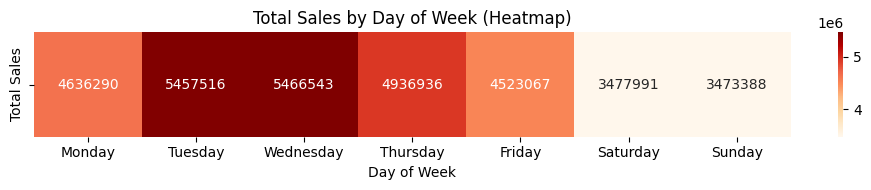

In [33]:
# Group only by date
daily_sales = (df[df['product_price'].notna()].groupby('date')['product_price'].sum().reset_index(name='total_sales'))

# Add weekday number and name
daily_sales['weekday'] = daily_sales['date'].dt.dayofweek
daily_sales['weekday_name'] = daily_sales['date'].dt.day_name()

# Aggregate sales by day of the week, ordered Monday to Sunday
sales_by_weekday = (daily_sales.groupby('weekday_name')['total_sales']
                    .sum()
                    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
                    .reset_index())

# Plot heatmap
plt.figure(figsize=(10, 2))
sns.heatmap([sales_by_weekday['total_sales']],
            annot=True, fmt='.0f', cmap='OrRd',
            xticklabels=sales_by_weekday['weekday_name'], yticklabels=['Total Sales'])

plt.title('Total Sales by Day of Week (Heatmap)')
plt.xlabel('Day of Week')
plt.ylabel('')
plt.tight_layout()
plt.show()



The highest sales volumes occur on Wednesday and Tuesday — over 5.4 million USD each day.

Thursday, Monday, and Friday show moderate levels — between 4.5 and 4.9 million USD.

Saturday and Sunday have the lowest volumes — less than 3.5 million USD.

The greatest sales are recorded on Tuesday and Wednesday, with the lowest on weekends. Sales during weekdays are significantly higher than on Saturday and Sunday.



Sales dynamics broken down by product categories

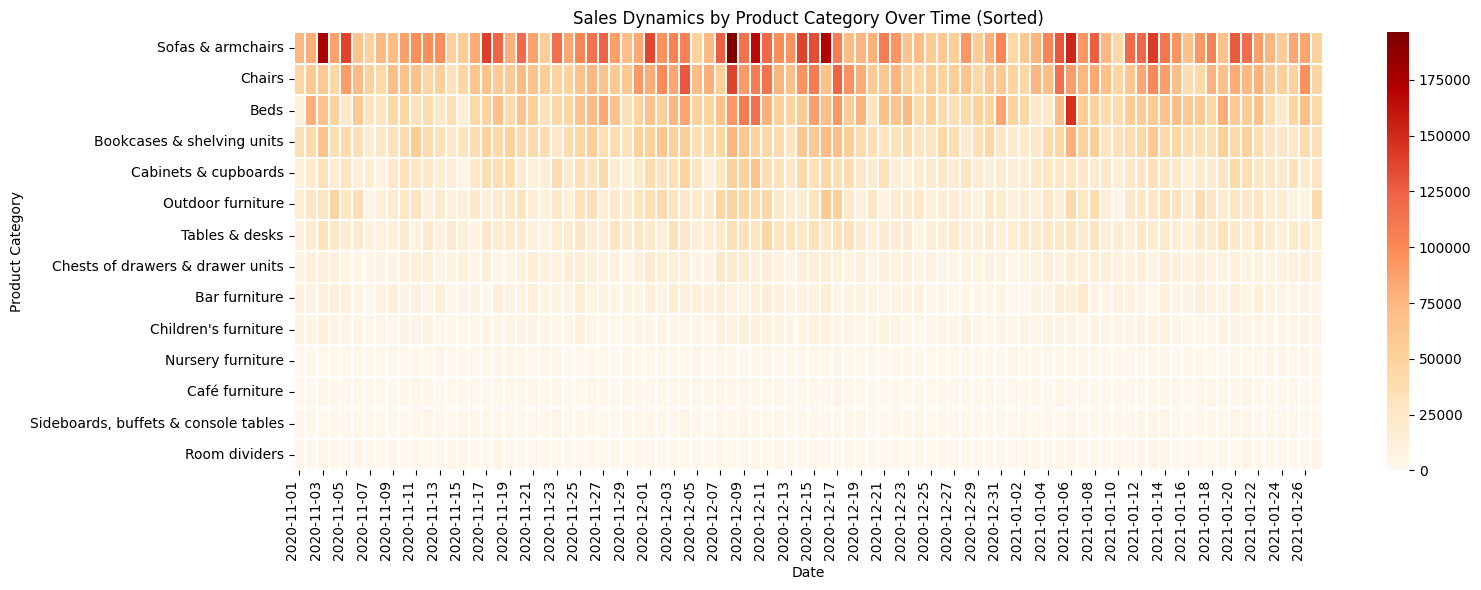

In [34]:
filtered_df = df[df['product_price'].notna()]

# Create a pivot table of sales dynamics by category and date
category_time_sales = (
    filtered_df
    .groupby(['date', 'product_category'])['product_price']
    .sum()
    .reset_index()
    .pivot(index='date', columns='product_category', values='product_price')
    .fillna(0)
)

# Convert index to DatetimeIndex and format dates
category_time_sales.index = pd.to_datetime(category_time_sales.index).strftime('%Y-%m-%d')

# Sort categories by total sales
sorted_categories = category_time_sales.sum(axis=0).sort_values(ascending=False).index

# Apply sorting
category_time_sales_sorted = category_time_sales[sorted_categories]

# Plot heatmap with sorted categories
plt.figure(figsize=(16, 6))
sns.heatmap(category_time_sales_sorted.T, cmap='OrRd', linewidths=0.3)

plt.title('Sales Dynamics by Product Category Over Time (Sorted)')
plt.xlabel('Date')
plt.ylabel('Product Category')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


"Sofas & armchairs" is the main revenue driver, with clearly visible periods of increased demand.

Seasonality is evident, with activity rising in December—likely due to pre-holiday demand.

Several categories exhibit very weak or sporadic sales, which may indicate:

Lower demand

Limited supply

A niche market

# Calculations by traffic channels

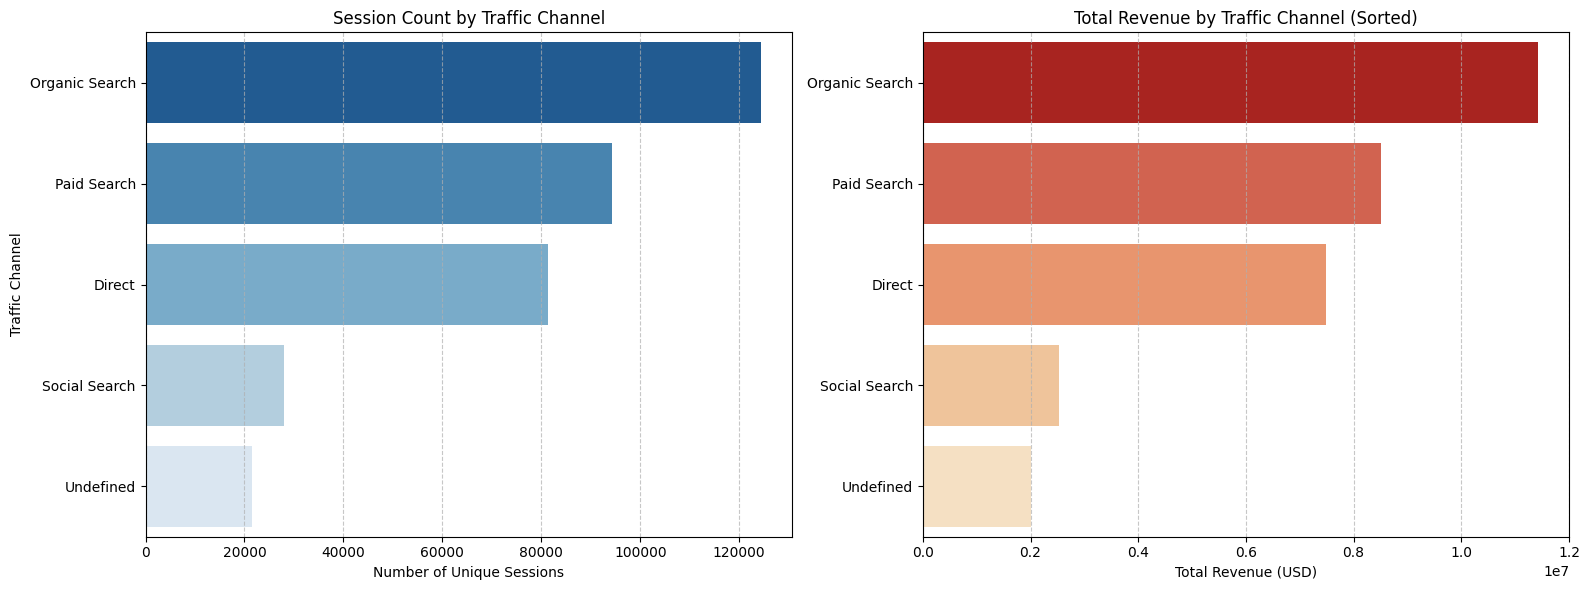

In [35]:
# Pivot table: sessions
session_pivot = (
    df[df['traffic_channel'].notna()]
    .groupby('traffic_channel')['ga_session_id']
    .nunique()
    .reset_index(name='session_count')
    .sort_values(by='session_count', ascending=False)
)

# Pivot table: revenue
revenue_pivot = (
    df[df['product_price'].notna() & df['traffic_channel'].notna()]
    .groupby('traffic_channel')['product_price']
    .sum()
    .reset_index()
    .sort_values(by='product_price', ascending=False)
)

# Plotting charts
plt.figure(figsize=(16, 6))

# Chart 1: sessions
plt.subplot(1, 2, 1)
sns.barplot(
    data=session_pivot,
    x='session_count',
    y='traffic_channel',
    hue='traffic_channel',
    palette='Blues_r',
    legend=False
)
plt.title('Session Count by Traffic Channel')
plt.xlabel('Number of Unique Sessions')
plt.ylabel('Traffic Channel')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Chart 2: revenue
plt.subplot(1, 2, 2)
sns.barplot(
    data=revenue_pivot,
    x='product_price',
    y='traffic_channel',
    hue='traffic_channel',
    palette='OrRd_r',
    legend=False
)
plt.title('Total Revenue by Traffic Channel (Sorted)')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Organic Search is the leader in both traffic and revenue.

Paid Search and Direct show similar results, but Direct demonstrates higher session efficiency (fewer sessions generating nearly the same revenue).

Social Search and Undefined are channels with the lowest activity and smallest financial contribution.

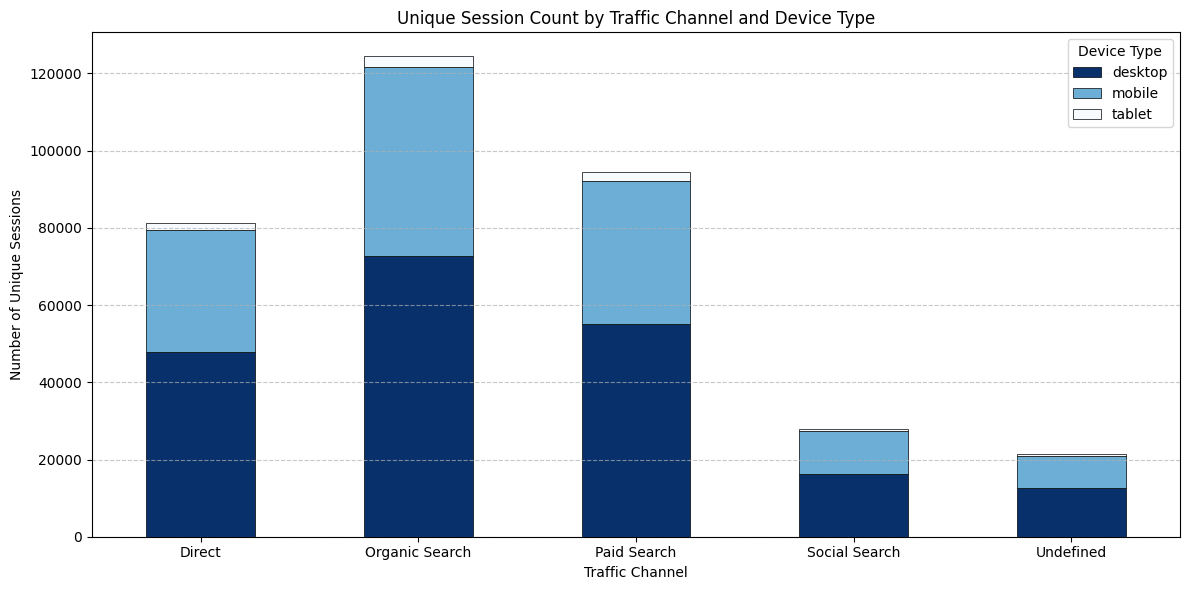

In [36]:
# Create pivot table: count of unique sessions by traffic channel and device type
session_by_channel_device = (
    df[df['traffic_channel'].notna() & df['device'].notna()]
    .groupby(['traffic_channel', 'device'])['ga_session_id']
    .nunique()
    .reset_index(name='session_count')
    .sort_values(by='session_count', ascending=False)
)

# Sort by traffic channel, then by device type
session_sorted = session_by_channel_device.sort_values(by=['traffic_channel', 'device'])

# Prepare data for plotting (pivot: rows=traffic_channel, columns=device)
pivot_df = session_sorted.pivot(index='traffic_channel', columns='device', values='session_count').fillna(0)

# Plot stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Blues_r', edgecolor='black', linewidth=0.5)

plt.title('Unique Session Count by Traffic Channel and Device Type')
plt.xlabel('Traffic Channel')
plt.ylabel('Number of Unique Sessions')
plt.xticks(rotation=0)
plt.legend(title='Device Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Organic Search is the primary traffic source across all device types.

Desktop dominates as the largest traffic source in all channels.

Mobile consistently ranks second and holds significant weight, especially in Organic and Paid Search.

Tablet remains a marginal device across all channels (approximately 1–3%).

Social Search and Undefined are the least effective in reach regardless of device type.

# Statistical relationships

Relationship between session count and total sales per date

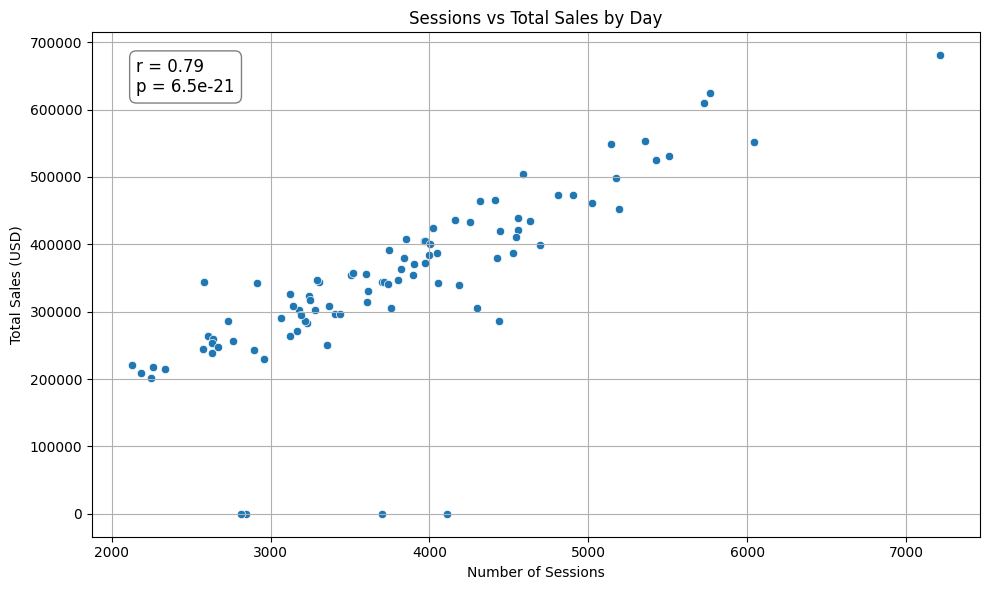

In [37]:
# Group by date: count of unique sessions and sum of sales
daily_summary = (
    df[df['ga_session_id'].notna()]
    .groupby('date')
    .agg(
        session_count=('ga_session_id', 'nunique'),
        total_sales=('product_price', 'sum')
    )
    .reset_index()
)

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(daily_summary['session_count'], daily_summary['total_sales'])

# Visualization: scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily_summary, x='session_count', y='total_sales')
plt.title('Sessions vs Total Sales by Day')
plt.xlabel('Number of Sessions')
plt.ylabel('Total Sales (USD)')
plt.text(
    0.05, 0.95,
    f"r = {correlation:.2f}\np = {p_value:.1e}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray')
)
plt.grid(True)
plt.tight_layout()
plt.show()

Pearson correlation coefficient: r = 0.79 — strong positive correlation.

This means that the higher the number of sessions per day, the higher the total sales overall.

Statistical significance: p-value ≈ 6.48e-21 — a very small value.

This indicates high statistical significance: the probability that this correlation occurred by chance is practically zero.

Conclusion: The data confirms a strong linear relationship between traffic (sessions) and revenue.

This suggests that investing in traffic acquisition can be effective, provided average order value and conversion rates remain stable.

Check correlation of sales between different continents (North America, Asia, Europe)

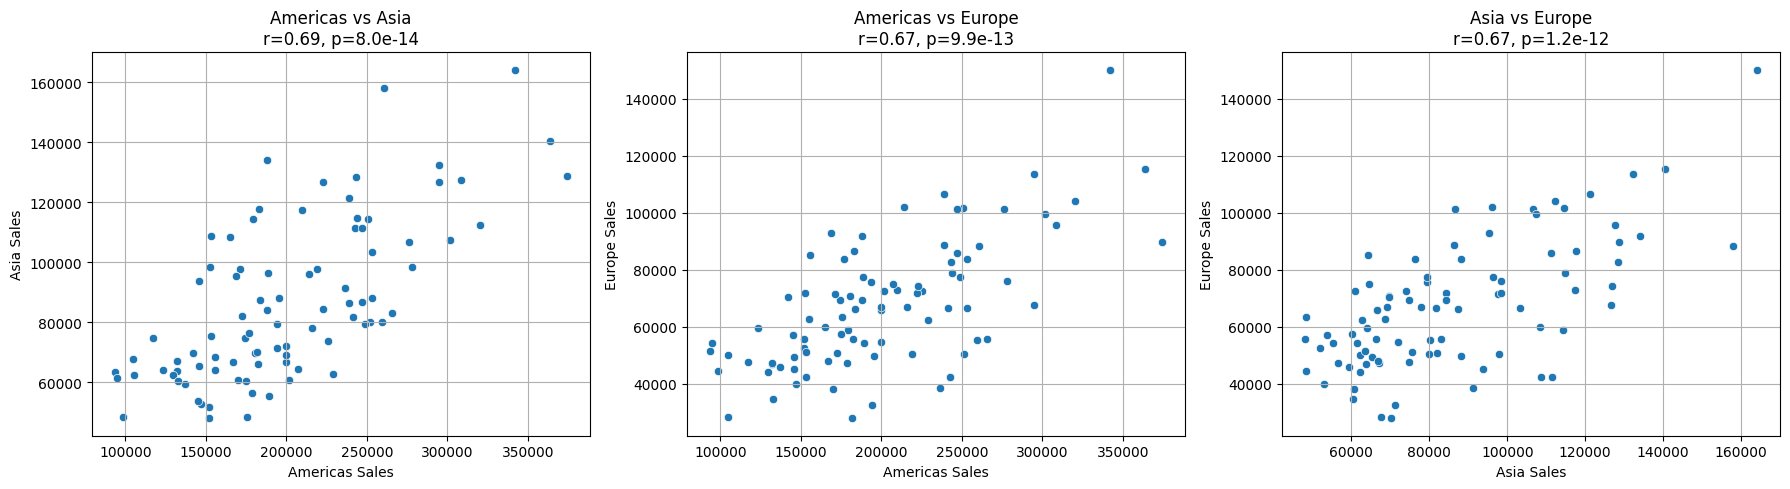

In [38]:
# Select valid values
continent_sales = df[df['product_price'].notna() & df['continent'].notna()]

# Top 3 continents by total sales volume
top3_continents = (
    continent_sales.groupby('continent')['product_price']
    .sum()
    .nlargest(3)
    .index
)

# Filter only top 3 continents
top_continent_data = continent_sales[continent_sales['continent'].isin(top3_continents)]

# Create table: sum of sales by each day and continent
daily_continent_sales = (
    top_continent_data.groupby(['date', 'continent'])['product_price']
    .sum()
    .reset_index()
    .pivot(index='date', columns='continent', values='product_price')
    .fillna(0)
)

# Calculate correlation coefficients and p-values for each pair
from scipy.stats import pearsonr
from itertools import combinations

correlation_results = []

for c1, c2 in combinations(daily_continent_sales.columns, 2):
    r, p = pearsonr(daily_continent_sales[c1], daily_continent_sales[c2])
    correlation_results.append({'continent_pair': f'{c1} & {c2}', 'r': r, 'p_value': p})

correlation_df = pd.DataFrame(correlation_results)

# Plot scatter plots for each continent pair
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Visualization for each pair
for ax, (c1, c2) in zip(axs, combinations(daily_continent_sales.columns, 2)):
    sns.scatterplot(
        x=daily_continent_sales[c1],
        y=daily_continent_sales[c2],
        ax=ax
    )
    r, p = pearsonr(daily_continent_sales[c1], daily_continent_sales[c2])
    ax.set_title(f'{c1} vs {c2}\nr={r:.2f}, p={p:.1e}')
    ax.set_xlabel(f'{c1} Sales')
    ax.set_ylabel(f'{c2} Sales')
    ax.grid(True)

plt.tight_layout()
plt.show()


All pairs of continents show a strong positive correlation in sales.

p-values are less than 0.001 for each pair, indicating statistically significant relationships.

This means that spikes or declines in one region often coincide with others, likely due to:

Global campaigns/promotions,

Seasonal factors (e.g., winter holidays),

Coordinated marketing activities.

Check correlation of sales between different traffic channels

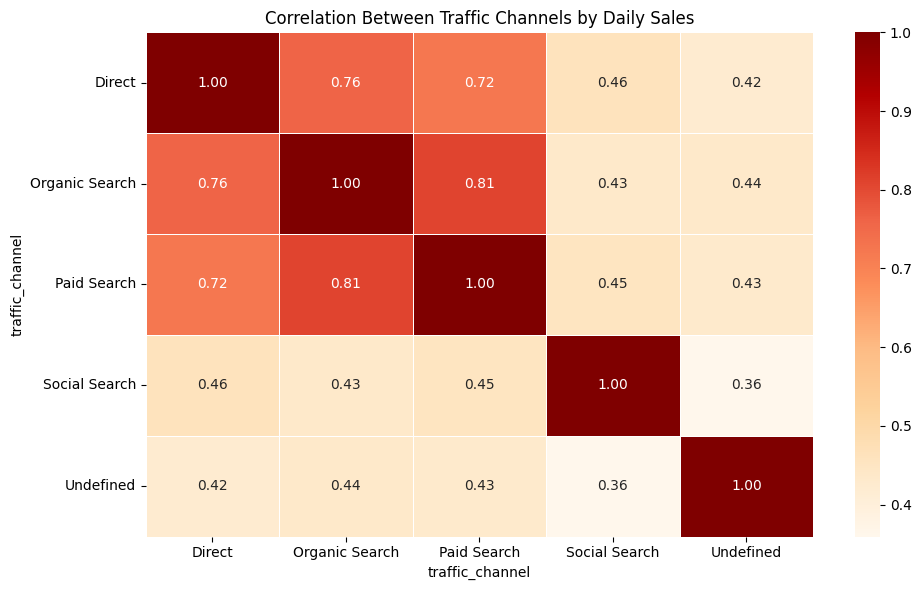

,channel_pair,p_value
0,Direct & Organic Search,9.107881e-18
1,Direct & Paid Search,1.512880e-15
2,Direct & Social Search,5.901047e-06
3,Direct & Undefined,3.838547e-05
4,Organic Search & Paid Search,1.755643e-21
5,Organic Search & Social Search,2.347593e-05
6,Organic Search & Undefined,2.237821e-05
7,Paid Search & Social Search,9.696038e-06
8,Paid Search & Undefined,2.897496e-05
9,Social Search & Undefined,5.853111e-04


In [39]:
# Select valid values
channel_sales = df[df['product_price'].notna() & df['traffic_channel'].notna()]

# Create table: sum of sales by each day and traffic channel
daily_channel_sales = (
    channel_sales
    .groupby(['date', 'traffic_channel'])['product_price']
    .sum()
    .reset_index()
    .pivot(index='date', columns='traffic_channel', values='product_price')
    .fillna(0)
)

# Calculate correlation matrix
channel_corr = daily_channel_sales.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(channel_corr, annot=True, cmap='OrRd', linewidths=0.5, fmt=".2f")

plt.title('Correlation Between Traffic Channels by Daily Sales')
plt.tight_layout()
plt.show()

# Create DataFrame with channel pairs and p-values
channel_pvalues_df = pd.DataFrame([
    {
        'channel_pair': f'{c1} & {c2}',
        'p_value': pearsonr(daily_channel_sales[c1], daily_channel_sales[c2])[1]
    }
    for c1, c2 in combinations(daily_channel_sales.columns, 2)
])

channel_pvalues_df



Organic Search and Paid Search have the highest correlation — likely indicating interconnected campaigns or user behavior.

Direct also shows strong correlation with other major channels, especially Organic.

Social Search and Undefined are the least correlated with other channels.

Sales across most major traffic channels exhibit strong positive correlation. All channel pairs show positive correlation, which is statistically significant, indicating:

Simultaneous user activity across different sources;

Or synchronized marketing campaigns.

Check correlation of sales among top 5 product categories

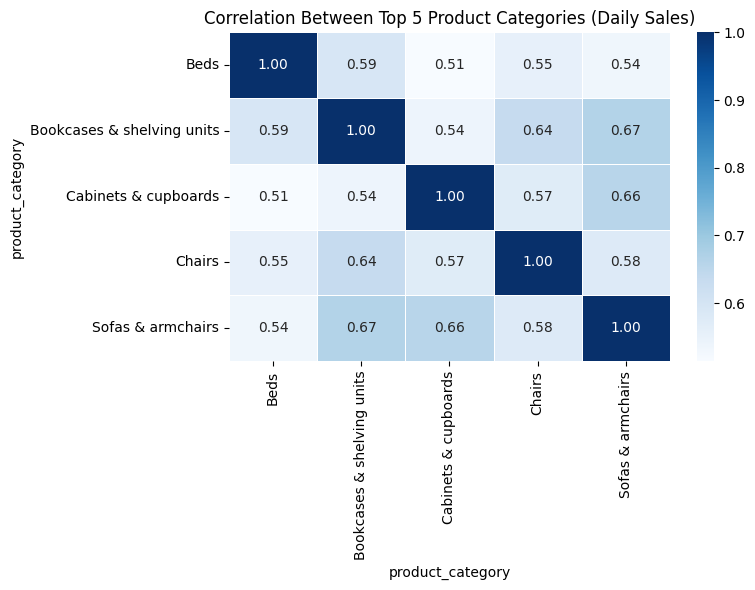

,category_pair,p_value
0,Beds & Bookcases & shelving units,1.154998e-09
1,Beds & Cabinets & cupboards,2.910930e-07
2,Beds & Chairs,2.079183e-08
3,Beds & Sofas & armchairs,7.687333e-08
4,Bookcases & shelving units & Cabinets & cupboards,5.867225e-08
5,Bookcases & shelving units & Chairs,2.504550e-11
6,Bookcases & shelving units & Sofas & armchairs,1.406972e-12
7,Cabinets & cupboards & Chairs,5.465903e-09
8,Cabinets & cupboards & Sofas & armchairs,3.415056e-12
9,Chairs & Sofas & armchairs,3.638833e-09


In [40]:
# Sample: only valid categories and prices
category_sales = df[df['product_price'].notna() & df['product_category'].notna()]

# Top 5 categories by total sales
top5_categories = (
    category_sales.groupby('product_category')['product_price']
    .sum()
    .nlargest(5)
    .index
)

# Filter by top 5 categories
filtered_top5 = category_sales[category_sales['product_category'].isin(top5_categories)]

# Table: sum of sales by each day and category
daily_category_sales = (
    filtered_top5
    .groupby(['date', 'product_category'])['product_price']
    .sum()
    .reset_index()
    .pivot(index='date', columns='product_category', values='product_price')
    .fillna(0)
)

# Calculate p-value for each pair of categories
category_pvalues_df = pd.DataFrame([
    {
        'category_pair': f'{c1} & {c2}',
        'p_value': pearsonr(daily_category_sales[c1], daily_category_sales[c2])[1]
    }
    for c1, c2 in combinations(daily_category_sales.columns, 2)
])

# Calculate Pearson correlation matrix among top 5 categories
category_corr = daily_category_sales.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(category_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)

plt.title('Correlation Between Top 5 Product Categories (Daily Sales)')
plt.tight_layout()
plt.show()

category_pvalues_df


The Pearson correlation matrix shows r values ranging from 0.51 to 0.67.

All p-values are < 0.001, indicating high statistical significance of the relationships between categories.

Interpretation:
Sales among the top categories have a moderate positive correlation.

The strongest correlations were observed between:

Sofas & armchairs ↔ Bookcases (r = 0.67)

Sofas & armchairs ↔ Cabinets (r = 0.66)

Chairs ↔ Bookcases (r = 0.64)

This suggests that demand in these categories rises and falls synchronously, possibly due to:

Joint marketing campaigns,

Seasonal promotions,

A tendency to purchase furniture sets (e.g., sofa + shelving + cabinet).

Conclusion:
Yes, sales among the top 5 categories are correlated, and this relationship is statistically significant. This insight can be used for sales forecasting or planning cross-promotions among related products.

# Statistical analysis of differences between user groups

Analysis of daily sales by number of purchases for registered and unregistered users

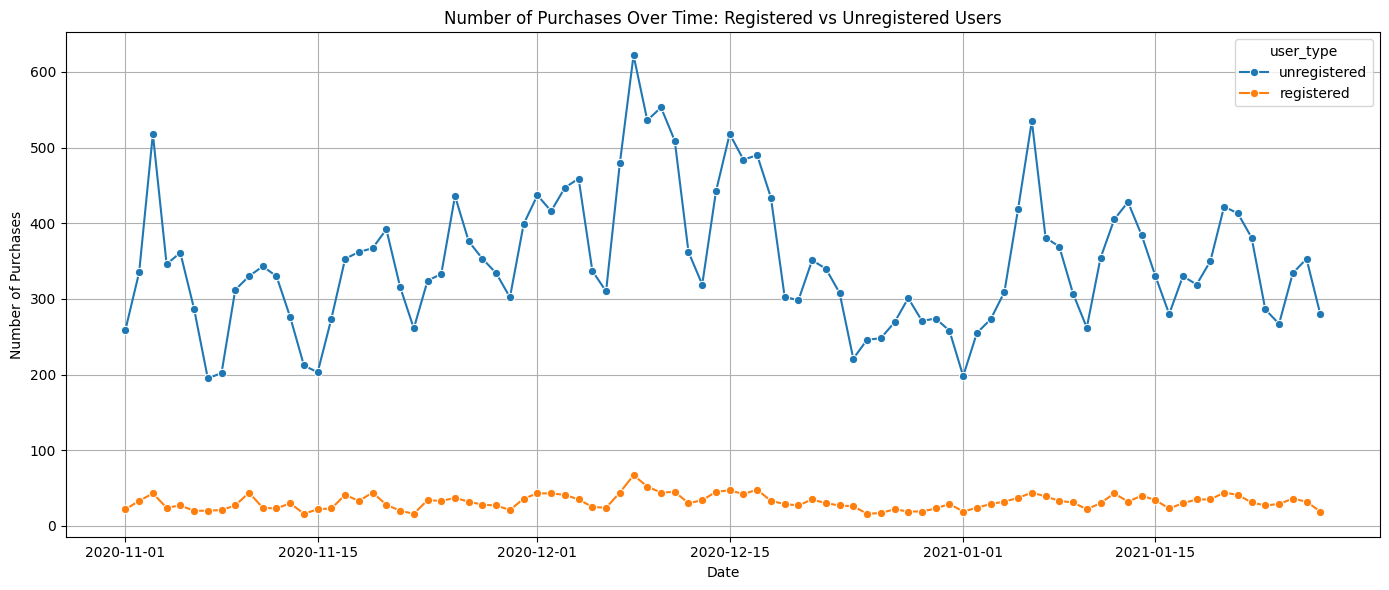

In [41]:
df['is_registered'] = df['account_id'].notna()
df['is_purchase'] = df['product_price'].notna()

# Count purchases by date and user type
purchase_counts = (
    df.query("is_purchase")
    .groupby(['date', 'is_registered'])['ga_session_id']
    .count()
    .reset_index()
    .rename(columns={'ga_session_id': 'purchase_count'})
)

# Map to user-friendly labels
purchase_counts['user_type'] = purchase_counts['is_registered'].map({True: 'registered', False: 'unregistered'})

# Plot the graph
plt.figure(figsize=(14, 6))
sns.lineplot(data=purchase_counts, x='date', y='purchase_count', hue='user_type', marker='o')
plt.title('Number of Purchases Over Time: Registered vs Unregistered Users')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.grid(True)
plt.tight_layout()
plt.show()



It is clearly visible that unregistered users make significantly more purchases in absolute terms.

Data for registered users are more stable but lower in volume.



Build histograms and check normality of distributions to select the appropriate statistical test

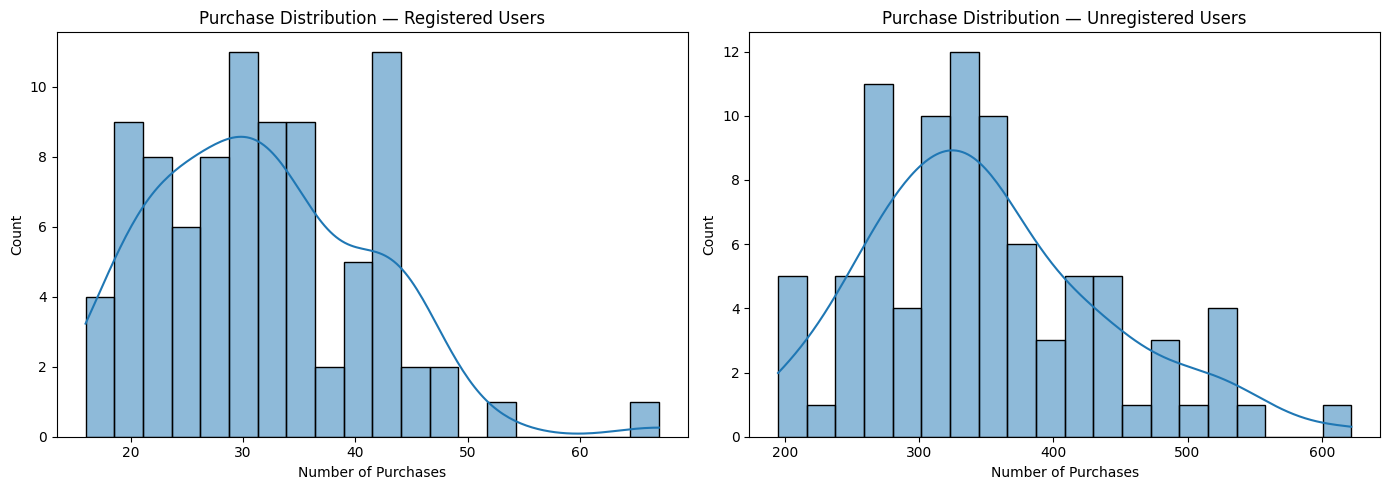

(ShapiroResult(statistic=np.float64(0.9575441485164817), pvalue=np.float64(0.005719393750019619)),
 ShapiroResult(statistic=np.float64(0.9631653477233061), pvalue=np.float64(0.013340679715658147)))

In [42]:
# Split into two samples: daily purchase counts
registered_daily = df.query("is_registered and is_purchase").groupby('date')['ga_session_id'].count()
unregistered_daily = df.query("not is_registered and is_purchase").groupby('date')['ga_session_id'].count()

# Plot histograms
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(registered_daily, bins=20, kde=True)
plt.title("Purchase Distribution — Registered Users")
plt.xlabel("Number of Purchases")

plt.subplot(1, 2, 2)
sns.histplot(unregistered_daily, bins=20, kde=True)
plt.title("Purchase Distribution — Unregistered Users")
plt.xlabel("Number of Purchases")

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
shapiro_registered = shapiro(registered_daily)
shapiro_unregistered = shapiro(unregistered_daily)

shapiro_registered, shapiro_unregistered


Since the p-value is less than 0.05 in both cases, we reject the null hypothesis of normal distribution.

Conclusion:
To compare the daily number of purchases between groups, a non-parametric test should be used, for example:

Mann–Whitney U test — to check if the distributions differ significantly.

In [43]:
from scipy.stats import mannwhitneyu
# Create samples — daily purchase counts
registered_daily = df.query("is_registered and is_purchase").groupby('date')['ga_session_id'].count()
unregistered_daily = df.query("not is_registered and is_purchase").groupby('date')['ga_session_id'].count()

# Perform Mann–Whitney U test

u_stat, p_val = mannwhitneyu(registered_daily, unregistered_daily, alternative='two-sided')

u_stat, p_val

(np.float64(0.0), np.float64(2.1786719630443014e-30))

Conclusion:
Since the p-value ≪ 0.05, we reject the null hypothesis:

The distributions of daily purchase counts between registered and unregistered users are statistically different.

Let’s determine the difference in conversion rates between registered and unregistered buyers using a proportion test (z-test).

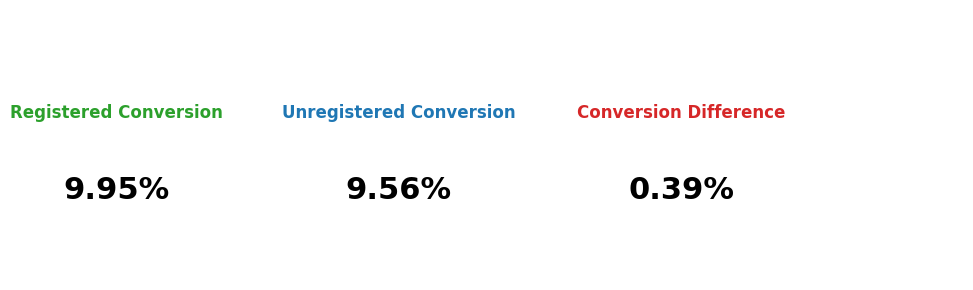

In [44]:
from statsmodels.stats.proportion import proportions_ztest

# Add 'is_purchase' column
df['is_purchase'] = df['product_price'].notna()

# Create table with count of unique sessions
session_counts = df.groupby(['date', 'is_registered'])['ga_session_id'].nunique().unstack(fill_value=0)

# Create sales table by date
registered_sales = df[df['is_registered']].groupby('date')['product_price'].sum()
unregistered_sales = df[~df['is_registered']].groupby('date')['product_price'].sum()
sales_comparison = pd.DataFrame({
    'registered': registered_sales,
    'unregistered': unregistered_sales
}).fillna(0)
sales_comparison['registered_sessions'] = session_counts.get(True, 0)
sales_comparison['unregistered_sessions'] = session_counts.get(False, 0)

# Count purchases
purchase_counts = (
    df[df['is_purchase']]
    .groupby(['date', 'is_registered'])['ga_session_id']
    .count()
    .unstack(fill_value=0)
)

# Total purchases and sessions
purchase_r = purchase_counts[True].sum()
purchase_unr = purchase_counts[False].sum()
session_r = sales_comparison['registered_sessions'].sum()
session_unr = sales_comparison['unregistered_sessions'].sum()

# Z-test for proportions
z_stat, p_value = proportions_ztest([purchase_r, purchase_unr], [session_r, session_unr])

# Conversion rates
conv_r = purchase_r / session_r
conv_unr = purchase_unr / session_unr
conv_diff = conv_r - conv_unr

# Output results
results = {
    "Registered Conversion (%)": round(conv_r * 100, 4),
    "Unregistered Conversion (%)": round(conv_unr * 100, 4),
    "Z-statistic": round(z_stat, 2),
    "P-value": round(p_value, 4),
    "Conversion Difference (%)": round(conv_diff * 100, 4)
}

# Create KPI tiles
fig, ax = plt.subplots(figsize=(10, 3))
fig.patch.set_facecolor('white')
ax.axis('off')

# Data for display
kpi_data = [
    ("Registered Conversion", f"{conv_r * 100:.2f}%", "#2ca02c"),
    ("Unregistered Conversion", f"{conv_unr * 100:.2f}%", "#1f77b4"),
    ("Conversion Difference", f"{conv_diff * 100:.2f}%", "#d62728")
]

# Display tiles
for i, (label, value, color) in enumerate(kpi_data):
    ax.text(0.1 + i * 0.3, 0.6, label, fontsize=12, weight='bold', color=color, ha='center')
    ax.text(0.1 + i * 0.3, 0.3, value, fontsize=22, weight='bold', color='black', ha='center')

plt.tight_layout()
plt.show()


We have determined that there is a statistically significant difference in conversion rates between registered and unregistered users.

Registered users make purchases more frequently, although the difference is small (~0.4% absolute difference in conversion rate).

Check if the proportion of sessions from organic traffic differs statistically between Europe and Americas








In [45]:
# Filter only Europe and Americas, and only organic and non-organic traffic
df_filtered = df.loc[df["continent"].isin(["Europe", "Americas"])].copy()
df_filtered["is_organic"] = df_filtered["traffic_channel"] == "Organic Search"

# Group by continent and count organic sessions and total sessions
sessions_by_continent = (
    df_filtered.groupby("continent")["is_organic"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "organic_sessions", "count": "total_sessions"})
    .assign(non_organic_sessions=lambda x: x["total_sessions"] - x["organic_sessions"])
)

# Prepare data for proportions test
counts = sessions_by_continent["organic_sessions"].values
nobs = sessions_by_continent["total_sessions"].values

# Z-test for proportions
z_stat, p_value = proportions_ztest(count=counts, nobs=nobs)

z_stat, p_value



(np.float64(-0.28951412926103953), np.float64(0.7721879690501752))

A two-proportion z-test was conducted to check whether the share of sessions from organic traffic differs between Europe and the Americas.

Test results:
z-statistic: -0.29
p-value: 0.772

Conclusion:
Since the p-value > 0.05, there is no statistically significant difference in the proportion of organic traffic sessions between Europe and the Americas.

In other words, organic traffic has a similar impact in both regions.








Summary and Conclusions:

1.Data Preparation Stage for Analysis

**Step 1:** Connecting to BigQuery and Creating the Dataset
Connected to Google BigQuery via API client.

Wrote an SQL query to select the necessary data.

Executed the query and retrieved the results as a DataFrame for further analysis.

**Step 2:** Familiarization with the Dataset
Data structure:

Total number of columns — 17.

Numeric columns — 5 (e.g., ga_session_id, email_verified, unsubscribed, account_id, product_price).

Categorical columns — 11 (continent, country, device, browser, operating_system, language, channel_info, traffic_channel, product_category, product_name, short_description).

Date column — 1 (order_date).

Missing values check:

Significant missing data in account_id, unsubscribed, email_verified columns (mostly related to unregistered users).

Product-related columns (product_name, product_category, product_price) also contain missing values, likely because some sessions had no product interaction.

Language is missing in about 33% of cases, possibly due to users not selecting a language or it not being captured.

Technical columns (ga_session_id, order_date, device, browser, country, etc.) have no missing values.

Data types:

Converted date columns to datetime64 type for easier analysis.

**Step 3:** Duplicate Check and Data Quality
Checked for complete duplicate rows — no duplicates found.

Performed descriptive statistics on numeric columns, especially product_price — all values positive, no zeros or negatives.

**Step 4**: Purchase Data Consistency
Verified that all rows with a product_name also have product_category and product_price present.

This indicates completeness and consistency of purchase-related data.



2. Загальна описова статистика

Conclusion on Key Dataset Metrics
The data covers 349,545 unique sessions over a 91-day period, including information from 5 continents and 107 countries. The analysis shows a wide range of user devices (3 types) and technical platforms (6 browsers, 6 operating systems), indicating a diverse audience.

The database includes 27,945 registered users, of whom 20,036 have verified their email, and 23,210 are subscribed to newsletters — metrics that reflect active user engagement.

Sales span 14 product categories and 550 unique items. The total number of purchases is 33,538, generating revenue of $31.97M with an  average order  value  of  $953.30.

A conversion rate of 9.59% demonstrates relatively high traffic and purchase efficiency.

These metrics indicate stable platform performance, broad geographic reach, diverse audience, and effective marketing and commercial activities. italicized text

3. Geographic Sales Analysis


Continents
Americas — the leader in total sales (about $17.7 million) and number of orders (over 18,500).

Asia — second in revenue (approximately $7.6 million) and order count (~7,950).

Europe — third in sales (around $5.9 million) and number of orders (~6,260).

Countries
The United States holds the top position in both sales (about $13.9 million) and number of orders (~14,670).

Followed by India and Canada, with sales around $2.8M  and  $2.4 million respectively.

Other leading countries include the United Kingdom, France, Spain, Germany, China, Taiwan, and Singapore, which have significant but relatively smaller sales volumes.

Conversion Rates by Country
The highest conversion rates are seen in Caribbean countries: Trinidad & Tobago (17.6%), Jamaica (17.0%), Malta (15.9%).

Other countries with high conversion rates include Georgia, Paraguay, Oman, Qatar, Finland, Pakistan, and Serbia — with conversions ranging from 12% to 14%.

The geographic analysis shows that the Americas are the primary market with the largest sales volume and order count. However, some smaller countries demonstrate high conversion rates, indicating potentially profitable niches for marketing efforts.

It is recommended to pay attention to regional purchasing behavior patterns and tailor marketing strategies according to conversion rates and sales volumes in different countries.

4. Sales Analysis by Product Categories

Top 10 Categories by Total Sales
Sofas & armchairs — the undisputed leader in total sales, indicating high demand for upholstered furniture.

Chairs — the second largest category, also enjoying strong demand.

Beds, Bookcases & shelving units, Cabinets & cupboards — consistently popular categories with significant sales volumes.

Other categories such as Outdoor furniture, Tables & desks, Bar furniture, Children’s furniture have smaller sales volumes but complement the overall assortment.

Sales by Categories in the USA
The top 10 categories in the USA closely mirror the global ranking, with Sofas & armchairs, Chairs, and Beds leading as well.

The USA contributes a significant share of global sales in the leading categories, highlighting the market’s importance.

Top 10 Products by Total Sales
The most profitable products are branded or popular models such as GRÖNLID, LIDHULT, VIMLE.

The significant sales gap between top products and others indicates a high revenue concentration on the most popular items.

Product Assortment by Category
The largest number of unique products is in the Chairs category (211 items), reflecting a wide variety in this segment.

Tables & desks, Bookcases & shelving units, and Beds also have a large assortment.

Niche categories like Café furniture, Nursery furniture, and Room dividers have minimal assortments.

Sales are mainly concentrated in several major furniture categories, particularly upholstered furniture and seating. Demand in the USA substantially influences the overall global outcome. The market offers a wide assortment in leading categories, indicating competitive supply, while niche categories with smaller assortments represent potential growth areas.

5. Sales Analysis by Device Type and User Status

Sales Distribution by Device Type
Desktop is the dominant channel, accounting for about 59% of total sales volume.

Mobile holds a significant share of approximately 39%, highlighting the importance of the mobile audience.

Tablet is the smallest channel, with only a 2.3% share, indicating a minor role of tablets in sales.

Sales Distribution Between Registered and Guest Users
Guests (unregistered users) make up the vast majority of sales — about 91.9%.

Registered users account for only 8.1% of sales, indicating a limited base of registered buyers.

Average Order Value Comparison
The average order value for subscribed users is approximately $921.51.

The average order value for unsubscribed (opted-out) users is slightly higher — about $965.82.

6. Sales Dynamics Analysis



Overall Sales Dynamics:

Sales show a fluctuating pattern with pronounced peaks.

The median daily revenue is approximately $345,000.

Noticeable increases occur during the pre-holiday period (December), indicating seasonality.

Sales Dynamics by Continent:

The Americas contribute the main share of sales with regular peaks.

Asia and Europe show more stable but less pronounced fluctuations.

Other continents (Africa, Oceania) have minimal impact on overall dynamics.

Sales Dynamics by Traffic Channel:

Organic Search leads with the largest sales fluctuations.

Paid Search and Direct show similar trends but with lower volumes.

Social Search and Undefined channels have the lowest and more stable activity.

Sales by Device Type:

Desktop is the main channel with the highest sales and noticeable fluctuations.

Mobile shows a moderate level of sales with a similar pattern.

Tablet has the lowest level with almost no fluctuations.

Sales Dynamics by Day of the Week:

Highest sales occur on Tuesday and Wednesday.

Monday, Thursday, and Friday have moderate volumes.

Weekend days (Saturday, Sunday) have the lowest sales.

Sales Dynamics by Product Category:

The “Sofas & Armchairs” category leads in sales volume over time.

Demand peaks are observed in certain periods, again suggesting seasonality.

Other categories have more even or lower sales levels.

7. Traffic Channels and Device Types Analysis

Session Count by Traffic Channel
Organic Search leads in the number of unique sessions, followed by Paid Search and Direct. Social Search and Undefined have the lowest session counts.

Total Revenue by Traffic Channel
Organic Search also leads in revenue. Paid Search and Direct show similar patterns but generate less revenue compared to Organic Search. Social Search and Undefined contribute the least.

Unique Session Count by Traffic Channel and Device Type
Desktop is the largest source of sessions across all channels. Mobile ranks second, especially strong in Organic and Paid Search channels. Tablet sessions are minimal.

8. Analysis of Dependencies and Correlations


Relationship between Number of Sessions and Total Sales (Sessions vs Total Sales):
A strong positive correlation was found (r ≈ 0.79, p ≈ 6.5e-21), meaning: the more sessions per day, the higher the sales. This indicates a close connection between traffic and revenue.

Correlations between Sales on Different Continents:

Americas vs Asia: r = 0.69 (p ≈ 8.0e-14)

Americas vs Europe: r = 0.67 (p ≈ 9.9e-13)

Asia vs Europe: r = 0.67 (p ≈ 1.2e-12)

All relationships are statistically significant. This suggests simultaneous fluctuations in demand across major regions, likely due to global marketing campaigns or seasonality.

Correlation between Traffic Channels by Daily Sales:

The highest correlation is between Organic Search and Paid Search (r ≈ 0.81), indicating a connection between campaigns or user behavior.

Direct also strongly correlates with Organic Search and Paid Search (r ≈ 0.72-0.76).

Social Search and Undefined have the lowest correlation with other channels (≈ 0.36-0.46).

Overall, sales across main channels show a positive and statistically significant correlation, indicating synchronized activity.

Correlations between Top 5 Product Categories (Daily Sales):

Correlations range between 0.51 and 0.67, with all p-values < 0.001.

The highest relationships are between Sofas & armchairs ↔ Bookcases (r = 0.67), Sofas & armchairs ↔ Cabinets (r = 0.66), and Chairs ↔ Bookcases (r = 0.64).

This indicates that demand in these categories changes synchronously, possibly due to joint promotions or similar consumer patterns.

**The final outcome of this analysis was the creation of a dashboard in Tableau, which provides a comprehensive overview of the performance of the online furniture store.**

https://public.tableau.com/app/profile/oksana.sitalova/viz/Project_17484593647600/Dashboard1